# Фаза 2 • Неделя 8 • Среда
## Нейронные сети
### 🔥 PyTorch • CIFAR10

In [366]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms as T
from torch.nn import functional as F

import numpy as np
import torchutils as tu
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import mlflow.pytorch
import multiprocessing as mp

# Установите метод запуска процессов на 'spawn'
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)

torch.set_default_device("cuda")
config = {
    "batch_size": 2048,
    "learning_rate": 0.002,
    "epochs": 10,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "data_dir": "data/",
    "log_dir": "runs/experiment1",
}
DEVICE = config["device"]
GENERATOR = torch.Generator(device=DEVICE)
BATCH_SIZE = config["batch_size"]
mlflow.set_tracking_uri("http://localhost:5000")

plt.rcParams["figure.dpi"] = 300
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [232]:
def classification_metrics(
    y_true: torch.Tensor, y_pred: torch.Tensor, num_classes: int
):
    """
    Считает Accuracy, Precision и Recall для мультиклассовой классификации.

    Аргументы:
        y_true (Tensor): Истинные метки (shape: [N])
        y_pred (Tensor): Предсказанные метки (shape: [N])
        num_classes (int): Количество классов

    Возвращает:
        dict: {'accuracy': float, 'precision': Tensor[num_classes], 'recall': Tensor[num_classes]}
    """
    # Убедимся, что всё на одной видеокарте
    device = y_true.device
    y_pred = y_pred.to(device)
    y_pred = y_pred.argmax(axis=1)
    # Accuracy
    accuracy = (y_true == y_pred).float().mean().item()

    # Матрица ошибок
    conf_matrix = torch.zeros(num_classes, num_classes, device=device)
    for t, p in zip(y_true, y_pred):
        conf_matrix[t, p] += 1

    # True Positive, False Positive, False Negative
    TP = conf_matrix.diag()
    FP = conf_matrix.sum(0) - TP
    FN = conf_matrix.sum(1) - TP

    precision_per_class = TP / (TP + FP + 1e-8)
    recall_per_class = TP / (TP + FN + 1e-8)
    f1_per_class = (
        2
        * precision_per_class
        * recall_per_class
        / (precision_per_class + recall_per_class + 1e-8)
    )

    return {
        "accuracy": accuracy,
        "precision": precision_per_class.mean().item(),
        "recall": recall_per_class.mean().item(),
        "f1": f1_per_class.mean().item(),
    }

In [233]:
def plot_history(history, grid=True, suptitle="model 1"):
    fig, ax = plt.subplots(3, 2, figsize=(16, 20))
    fig.suptitle(suptitle, fontsize=24, fontweight="bold", y=0.85)
    ax[0][0].plot(history["train_losses"], label="train loss")
    ax[0][0].plot(history["valid_losses"], label="valid loss")
    ax[0][0].set_title(f'Loss on epoch {len(history["train_losses"])}', fontsize=16)
    ax[0][0].grid(grid)
    ax[0][0].set_ylim((0, max(history["train_losses"] + history["valid_losses"]) + 0.1))
    ax[0][0].legend(fontsize=14)
    ax[0][0].set_xlabel("Epoch", fontsize=14)
    ax[0][0].set_ylabel("Loss", fontsize=14)

    ax[0][1].plot(history["train_accs"], label="train acc")
    ax[0][1].plot(history["valid_accs"], label="valid acc")
    ax[0][1].set_title(f'Accuracy on epoch {len(history["train_losses"])}', fontsize=16)
    ax[0][1].grid(grid)
    ax[0][1].set_ylim((min(history["train_accs"]) - 0.05, 1))
    ax[0][1].legend(fontsize=14)
    ax[0][1].set_xlabel("Epoch", fontsize=14)
    ax[0][1].set_ylabel("Accuracy", fontsize=14)

    ax[1][0].plot(history["train_precs"], label="train prec")
    ax[1][0].plot(history["valid_precs"], label="valid prec")
    ax[1][0].set_title(
        f'Precision on epoch {len(history["train_losses"])}', fontsize=16
    )
    ax[1][0].grid(grid)
    ax[1][0].set_ylim(min(history["train_precs"]) - 0.05, 1)
    ax[1][0].legend(fontsize=14)
    ax[1][0].set_xlabel("Epoch", fontsize=14)
    ax[1][0].set_ylabel("Precision", fontsize=14)

    ax[1][1].plot(history["train_recals"], label="train recal")
    ax[1][1].plot(history["valid_recals"], label="valid recal")
    ax[1][1].set_title(f'Recal on epoch {len(history["train_losses"])}', fontsize=16)
    ax[1][1].grid(grid)
    ax[1][1].set_ylim((min(history["train_recals"]) - 0.05, 1))
    ax[1][1].legend(fontsize=14)
    ax[1][1].set_xlabel("Epoch", fontsize=14)
    ax[1][1].set_ylabel("Recal", fontsize=14)

    ax[2][0].plot(history["train_f1s"], label="train f1")
    ax[2][0].plot(history["valid_f1s"], label="valid f1")
    ax[2][0].set_title(f'F1-score on epoch {len(history["train_losses"])}', fontsize=16)
    ax[2][0].grid(grid)
    ax[2][0].set_ylim((min(history["train_f1s"]) - 0.05, 1))
    ax[2][0].legend(fontsize=14)
    ax[2][0].set_xlabel("Epoch", fontsize=14)
    ax[2][0].set_ylabel("F1", fontsize=14)
    plt.subplots_adjust(top=0.8)
    # plt.tight_layout(rect=[0, 0, 1, 0.8])
    plt.show()
    return fig

Воспользуемся известным датасетом [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), он содержит в себе изображения, принадлежащие 10 разным классам. 

![](https://3065708918-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LRrOFNeUGLZef_2NLZ0%2F-LeEJi2MCK6d2wToNmIy%2F-LeENgJqZAzBJi8PRELl%2Fcifar10.png?alt=media&token=bee1e40d-b4f6-4f46-a835-43d3f1223166)

Датасет уже есть в torchvision.datasets, потому загрузим его сразу в нужном формате. 

In [287]:
train_ds = CIFAR10(
    root="data/",
    download=True,
    train=True,
    transform=T.Compose(
        [
            T.Resize(
                (32, 32)
            ),  # на всякий случай применяем приведение к нужному размеру (тут он по умолчанию 32)
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # нормализация
        ]
    ),
)

valid_ds = CIFAR10(
    root="data/",
    download=True,
    train=False,
    transform=T.Compose(
        [
            T.Resize((32, 32)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

1. Создай два загрузчика (DataLoader): для обучающей и валидационной частей выборки. 

In [288]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    generator=GENERATOR,
)
valid_loader = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    generator=GENERATOR,
)

2. Задай класс модели в соответствии со схемой, приведенной ниже. 

![](img/base_cnn.png)

In [236]:
class BaseCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flat = nn.Flatten()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,  # (w - k +2*p) / s + 1
                out_channels=6,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=6,  # (w - k +2*p) / s + 1
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(8 * 8 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        x_1 = self.fc1(self.flat(out))
        x_2 = self.fc2(F.relu(x_1))
        x_3 = self.fc3(F.relu(x_2))
        x_final = x_3
        return x_final

In [237]:
base_cnn = BaseCNN()
base_cnn.to(DEVICE)

BaseCNN(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

3. Вызови функцию `get_model_summary` из бибилиотеки `torchutils`. 

In [238]:
tu.get_model_summary(base_cnn, torch.randn(32, 3, 32, 32, device=DEVICE))

Layer                     Kernel            Output        Params         FLOPs
0_layer1.Conv2d_0       [3, 6, 5, 5]    [32, 6, 32, 32]       456   14,942,208
1_layer1.ReLU_1                    -    [32, 6, 32, 32]         0            0
2_layer1.MaxPool2d_2               -    [32, 6, 16, 16]         0            0
3_layer2.Conv2d_0      [6, 16, 5, 5]   [32, 16, 16, 16]     2,416   19,791,872
4_layer2.ReLU_1                    -   [32, 16, 16, 16]         0            0
5_layer2.MaxPool2d_2               -     [32, 16, 8, 8]         0            0
6_flat                             -         [32, 1024]         0            0
7_fc1                    [1024, 120]          [32, 120]   123,000    7,860,480
8_fc2                      [120, 84]           [32, 84]    10,164      642,432
9_fc3                       [84, 10]           [32, 10]       850       53,440
Total params: 136,886
Trainable params: 136,886
Non-trainable params: 0
Total FLOPs: 43,290,432 / 43.29 MFLOPs
--------------------

In [239]:
use_mlflow = True

# Здесь можно выбрать или задать название эксперимента
# (если такового нет, MLflow создаст новый)
mlflow_experiment_name = "First-CNN-Experiment"

4. Задай функцию потерь и оптимизатор. 

In [240]:
optimizer = torch.optim.Adam(base_cnn.parameters(), config["learning_rate"])
criterion = torch.nn.CrossEntropyLoss()
n_classes = 10

5. Определи функцию `fit`, она должна возвращать данные, указанные в `docstring`. В функции должны присутствовать обучающие и валидационные шаги. 

In [ ]:
def fit_model(
    epochs: int,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.modules.loss.CrossEntropyLoss,
    train_loader=train_loader,
    valid_loader=valid_loader,
) -> dict:

    history = {
        "train_losses": [],
        "train_accs": [],
        "train_precs": [],
        "train_recals": [],
        "train_f1s": [],
        "valid_losses": [],
        "valid_accs": [],
        "valid_precs": [],
        "valid_recals": [],
        "valid_f1s": [],
    }
    start_epoch = len(history["train_accs"])

    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_accs = []
        batch_losses = []
        batch_precs = []
        batch_recals = []
        batch_f1s = []

        for samples, labels in train_loader:

            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(samples)

            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            metrics = classification_metrics(labels, y_pred, n_classes)
            batch_losses.append(loss.item())
            batch_precs.append(metrics["precision"])
            batch_accs.append(metrics["accuracy"])
            batch_recals.append(metrics["recall"])
            batch_f1s.append(metrics["f1"])

        history["train_losses"].append(np.mean(batch_losses))
        history["train_accs"].append(np.mean(batch_accs))
        history["train_precs"].append(np.mean(batch_precs))
        history["train_recals"].append(np.mean(batch_recals))
        history["train_f1s"].append(np.mean(batch_f1s))

        model.eval()
        batch_accs = []
        batch_losses = []
        batch_precs = []
        batch_recals = []
        batch_f1s = []
        for samples, labels in valid_loader:
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.no_grad():
                y_pred = model(samples)

            loss = criterion(y_pred, labels)

            metrics = classification_metrics(labels, y_pred, n_classes)
            batch_losses.append(loss.item())
            batch_precs.append(metrics["precision"])
            batch_accs.append(metrics["accuracy"])
            batch_recals.append(metrics["recall"])
            batch_f1s.append(metrics["f1"])

        history["valid_losses"].append(np.mean(batch_losses))
        history["valid_accs"].append(np.mean(batch_accs))
        history["valid_precs"].append(np.mean(batch_precs))
        history["valid_recals"].append(np.mean(batch_recals))
        history["valid_f1s"].append(np.mean(batch_f1s))

        # [MLflow] Логируем метрики
        if use_mlflow:
            # epoch – номер шага (можно указывать step=epoch)
            mlflow.log_metric("train_loss", history["train_losses"][-1], step=epoch)
            mlflow.log_metric("train_acc", history["train_accs"][-1], step=epoch)
            mlflow.log_metric("train_prec", history["train_precs"][-1], step=epoch)
            mlflow.log_metric("train_recal", history["train_recals"][-1], step=epoch)
            mlflow.log_metric("train_f1", history["train_f1s"][-1], step=epoch)
            mlflow.log_metric("valid_loss", history["valid_losses"][-1], step=epoch)
            mlflow.log_metric("valid_acc", history["valid_accs"][-1], step=epoch)
            mlflow.log_metric("valid_prec", history["valid_precs"][-1], step=epoch)
            mlflow.log_metric("valid_recal", history["valid_recals"][-1], step=epoch)
            mlflow.log_metric("valid_f1", history["valid_f1s"][-1], step=epoch)

        print(
            f'Train: loss {history["train_losses"][-1]:.4f}\n'
            f'accuracy {history["train_accs"][-1]:.4f}, F1-score {history["train_f1s"][-1]:.4f}\n'
            f'precision {history["train_precs"][-1]:.4f}, recal {history["train_recals"][-1]:.4f}\n'
            f'Valid: loss {history["valid_losses"][-1]:.4f}\n'
            f'accuracy {history["valid_accs"][-1]:.4f}, F1-score {history["valid_f1s"][-1]:.4f}\n'
            f'precision {history["valid_precs"][-1]:.4f}, recal {history["valid_recals"][-1]:.4f}\n'
        )
        print(f'{"-"*35}')
        print()

    return history

In [242]:
# [MLflow] Запуск эксперимента через контекстный менеджер
if use_mlflow:
    mlflow.set_experiment(
        mlflow_experiment_name
    )  # установить (или создать) эксперимент
    with mlflow.start_run(
        run_name=f"base_cnn_bs_{BATCH_SIZE}_lr_{config['learning_rate']}"
    ):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size", config["batch_size"])
        mlflow.log_param("learning_rate", config["learning_rate"])
        mlflow.log_param("epochs", config["epochs"])
        mlflow.log_param("device", config["device"])
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("criterion", criterion)

        # Запускаем обучение
        logs = fit_model(
            model=base_cnn,
            epochs=config["epochs"],
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            valid_loader=valid_loader,
        )

        # Сохраняем модель в MLflow (опционально)
        # mlflow.pytorch.log_model(base_cnn, "model")

    # После выхода из `with` Run автоматически завершается
else:
    # Если не используем MLflow
    logs = fit_model(
        model=base_cnn,
        epochs=config["epochs"],
        optimizer=optimizer,
        criterion=criterion,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

2025/09/10 13:59:10 INFO mlflow.tracking.fluent: Experiment with name 'First-CNN-Experiment' does not exist. Creating a new experiment.


------------- Epoch 1 -------------
Train: loss 1.8632
accuracy 0.3260, F1-score 0.2927
precision 0.3143, recal 0.3258
Valid: loss 1.5872
accuracy 0.4160, F1-score 0.3924
precision 0.4033, recal 0.4155

-----------------------------------

------------- Epoch 2 -------------
Train: loss 1.5018
accuracy 0.4526, F1-score 0.4424
precision 0.4592, recal 0.4532
Valid: loss 1.4170
accuracy 0.4847, F1-score 0.4703
precision 0.4859, recal 0.4841

-----------------------------------

------------- Epoch 3 -------------
Train: loss 1.3636
accuracy 0.5079, F1-score 0.4997
precision 0.5125, recal 0.5082
Valid: loss 1.3174
accuracy 0.5258, F1-score 0.5143
precision 0.5277, recal 0.5251

-----------------------------------

------------- Epoch 4 -------------
Train: loss 1.2661
accuracy 0.5472, F1-score 0.5412
precision 0.5509, recal 0.5478
Valid: loss 1.2621
accuracy 0.5458, F1-score 0.5348
precision 0.5542, recal 0.5454

-----------------------------------

------------- Epoch 5 -------------
Trai

6. Распечатай графики значений функции потерь на обучении и валидации, а также значения метрики на обучении и валидации. 

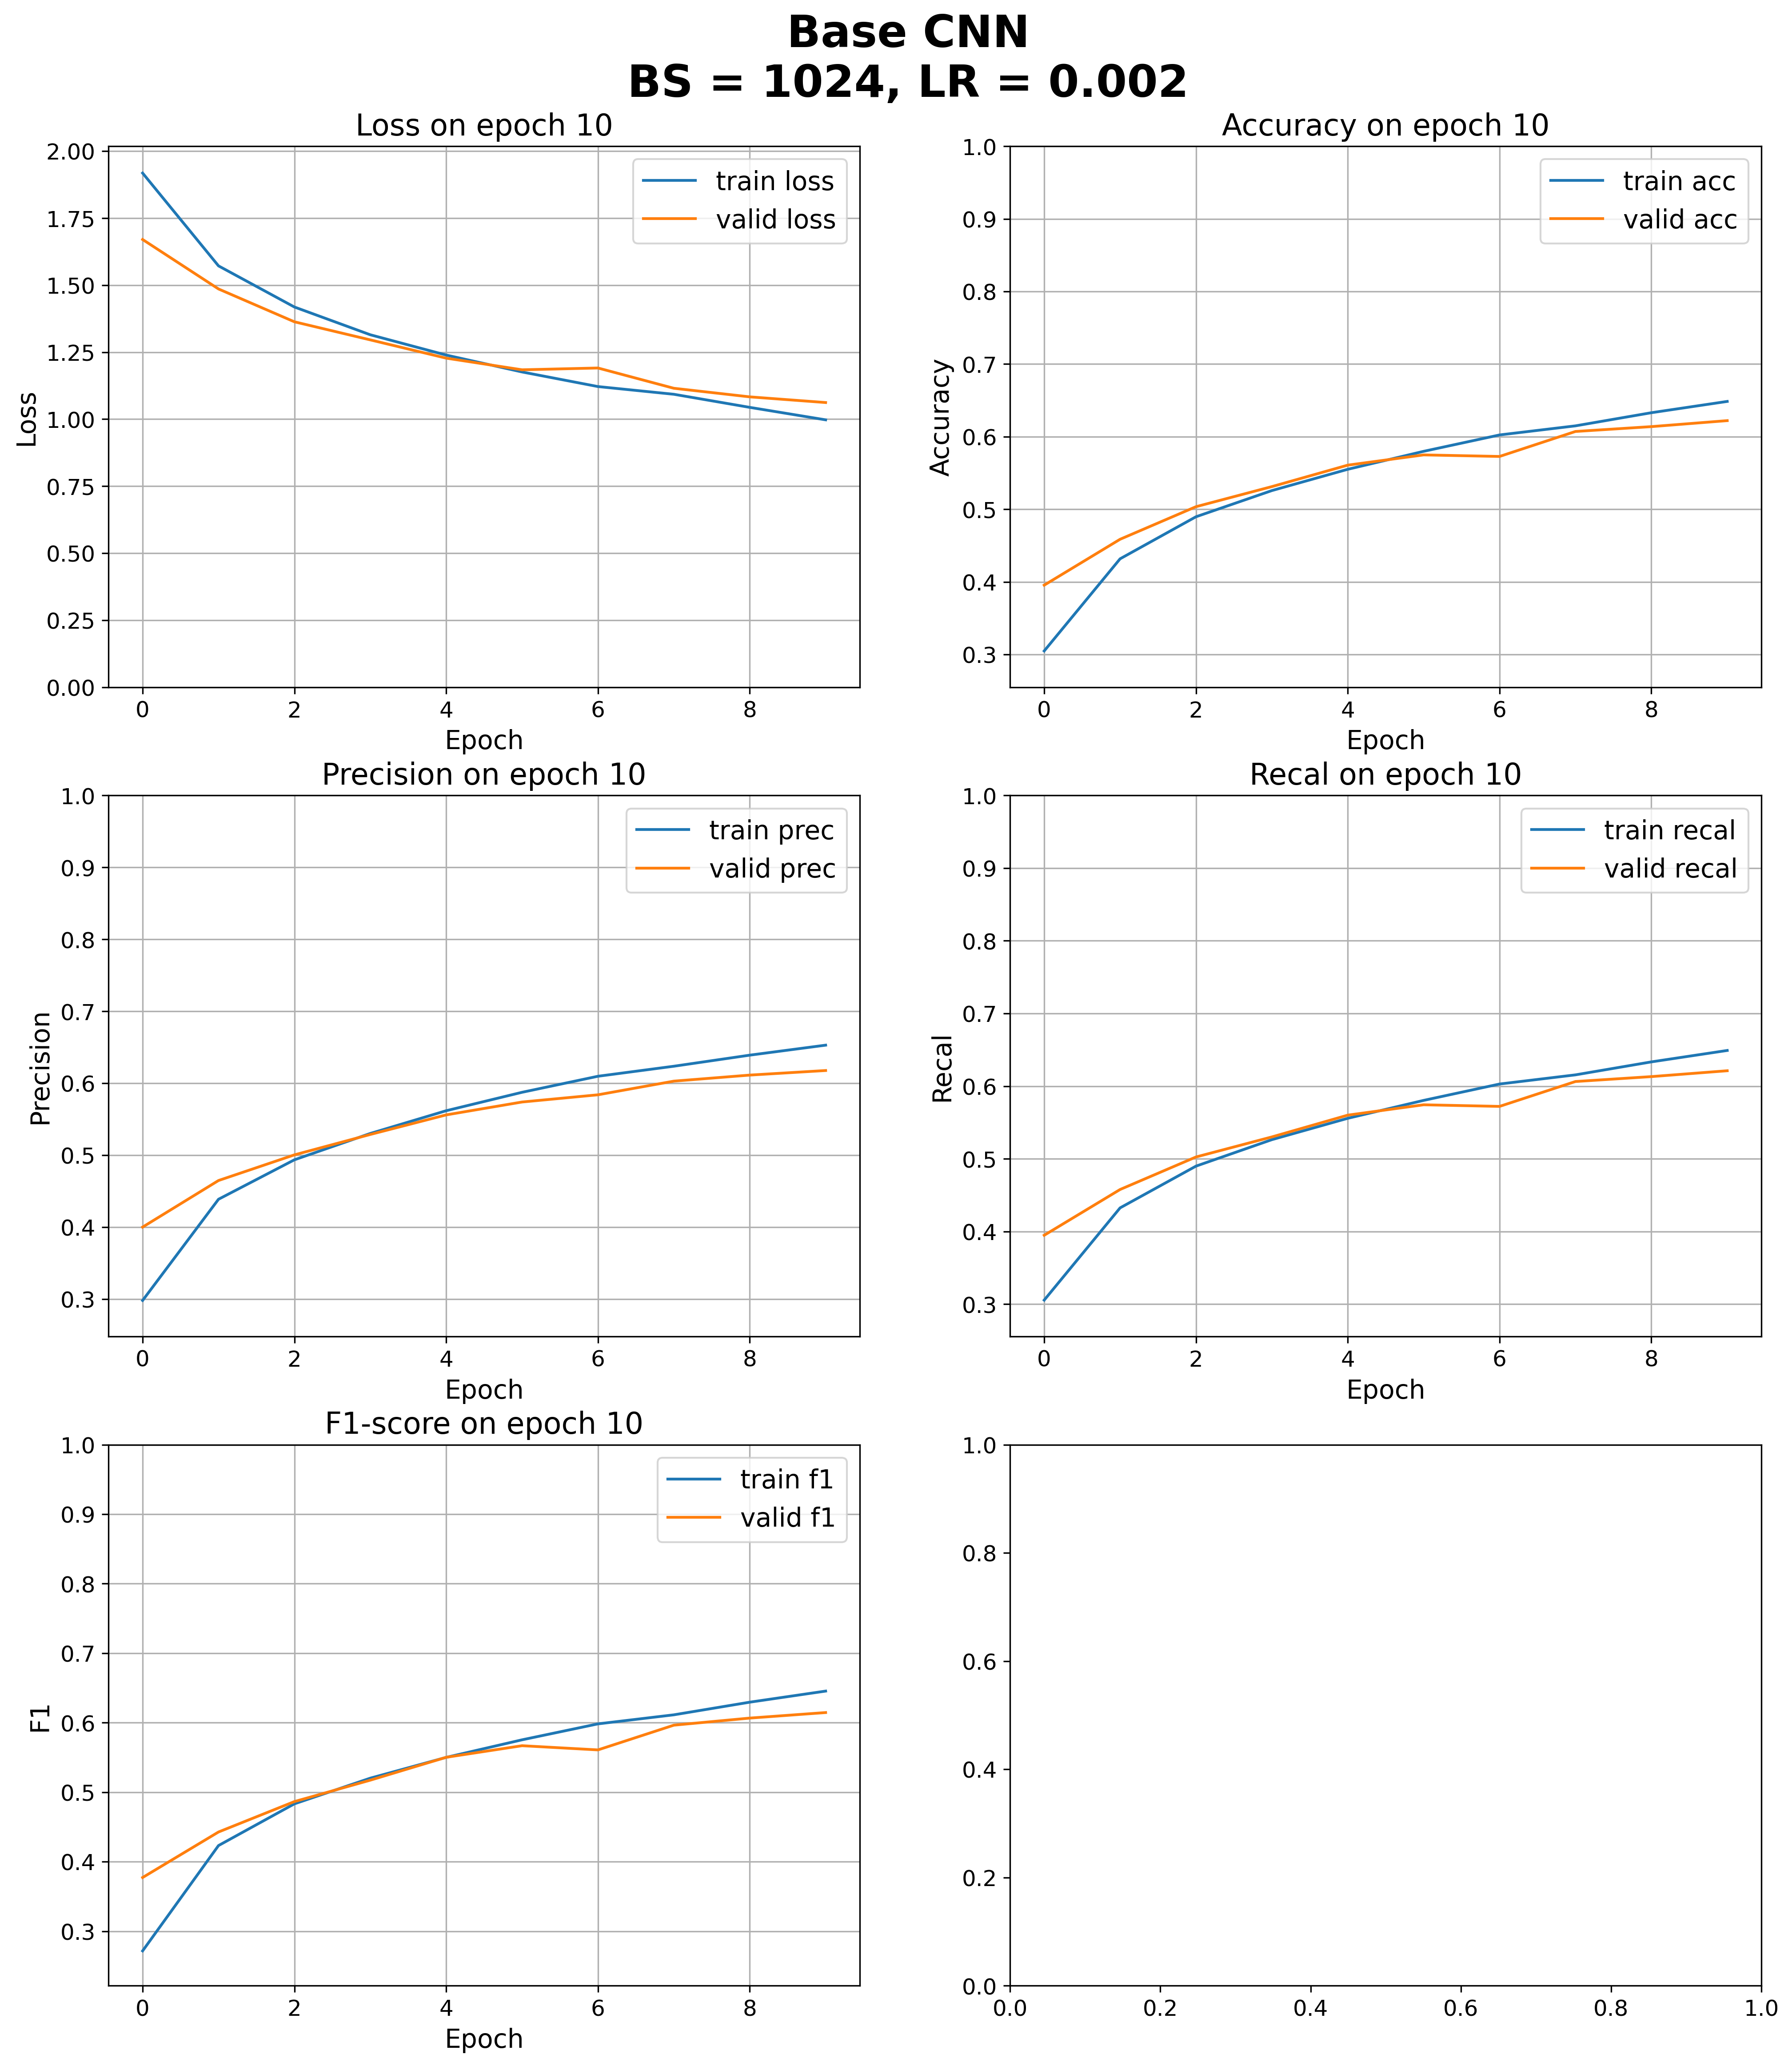

In [197]:
fig1 = plot_history(
    logs, suptitle=f"Base CNN\nBS = {BATCH_SIZE}, LR = {config['learning_rate']}"
)

In [198]:
fig1.savefig("results/imgs/Base CNN.png", bbox_inches="tight", pad_inches=0.5)

7. Запиши результаты в переменные/словарь для последующего сравнения их с результатами более сложных моделей. 

In [199]:
# code

8. Реализуй модель, изображенную на схеме ниже. 

![](img/modified_cnn.png)

In [200]:
class ModifiedCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flat = nn.Flatten()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,  # (w - k +2*p) / s + 1
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # на выходе 32х32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # на выходе 16x16
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,  # (w - k +2*p) / s + 1
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # на выходе 16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # на выходе 8x8
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,  # (w - k +2*p) / s + 1
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # на выходе 8x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # на выходе 4x4
        )
        self.fc1 = nn.Linear(4 * 4 * 64, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        x_1 = self.fc1(self.flat(out))
        x_2 = self.fc2(F.relu(x_1))
        x_3 = self.fc3(F.relu(x_2))
        x_final = x_3
        return x_final

In [201]:
modified_cnn = ModifiedCNN()
modified_cnn.to(DEVICE)

ModifiedCNN(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [202]:
tu.get_model_summary(modified_cnn, torch.randn(32, 3, 32, 32, device=DEVICE))

Layer                      Kernel            Output        Params         FLOPs
0_layer1.Conv2d_0       [3, 16, 3, 3]   [32, 16, 32, 32]       448   14,680,064
1_layer1.ReLU_1                     -   [32, 16, 32, 32]         0            0
2_layer1.MaxPool2d_2                -   [32, 16, 16, 16]         0            0
3_layer2.Conv2d_0      [16, 32, 3, 3]   [32, 32, 16, 16]     4,640   38,010,880
4_layer2.ReLU_1                     -   [32, 32, 16, 16]         0            0
5_layer2.MaxPool2d_2                -     [32, 32, 8, 8]         0            0
6_layer3.Conv2d_0      [32, 64, 3, 3]     [32, 64, 8, 8]    18,496   37,879,808
7_layer3.ReLU_1                     -     [32, 64, 8, 8]         0            0
8_layer3.MaxPool2d_2                -     [32, 64, 4, 4]         0            0
9_flat                              -         [32, 1024]         0            0
10_fc1                    [1024, 512]          [32, 512]   524,800   33,538,048
11_fc2                      [512, 64]   

9. Обучи модифицированную модель с помощью функции `fit()` и повтори шаги 6 и 7 для текущей модели. Не забудь передать в оптимизатор новые параметры (= создай его заново). 

In [203]:
lr2 = config["learning_rate"]
optimizer2 = torch.optim.Adam(modified_cnn.parameters(), lr2)
criterion2 = torch.nn.CrossEntropyLoss()

In [204]:
# [MLflow] Запуск эксперимента через контекстный менеджер
if use_mlflow:
    mlflow.set_experiment(
        f"{mlflow_experiment_name} - modified CNN"
    )  # установить (или создать) эксперимент
    with mlflow.start_run(run_name=f"base_cnn_bs_{BATCH_SIZE}_lr_{lr2}"):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size", config["batch_size"])
        mlflow.log_param("learning_rate", lr2)
        mlflow.log_param("epochs", config["epochs"])
        mlflow.log_param("device", config["device"])
        mlflow.log_param("optimizer", optimizer2)
        mlflow.log_param("criterion", criterion2)

        # Запускаем обучение
        logs_2 = fit_model(
            model=modified_cnn,
            epochs=config["epochs"],
            optimizer=optimizer2,
            criterion=criterion2,
            train_loader=train_loader,
            valid_loader=valid_loader,
        )

        # Сохраняем модель в MLflow (опционально)
        # mlflow.pytorch.log_model(base_cnn, "model")

    # После выхода из `with` Run автоматически завершается
else:
    # Если не используем MLflow
    logs_2 = fit_model(
        model=modified_cnn,
        epochs=config["epochs"],
        optimizer=optimizer2,
        criterion=criterion2,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

------------- Epoch 1 -------------
Train: loss 1.8856
accuracy 0.3098, F1-score 0.2769
precision 0.3132, recal 0.3111
Valid: loss 1.6287
accuracy 0.4032, F1-score 0.3831
precision 0.4106, recal 0.4029

-----------------------------------

------------- Epoch 2 -------------
Train: loss 1.5040
accuracy 0.4486, F1-score 0.4386
precision 0.4579, recal 0.4487
Valid: loss 1.4043
accuracy 0.4818, F1-score 0.4627
precision 0.4906, recal 0.4813

-----------------------------------

------------- Epoch 3 -------------
Train: loss 1.3413
accuracy 0.5098, F1-score 0.5025
precision 0.5196, recal 0.5099
Valid: loss 1.2749
accuracy 0.5360, F1-score 0.5261
precision 0.5405, recal 0.5354

-----------------------------------

------------- Epoch 4 -------------
Train: loss 1.2355
accuracy 0.5513, F1-score 0.5451
precision 0.5608, recal 0.5512
Valid: loss 1.1722
accuracy 0.5769, F1-score 0.5692
precision 0.5767, recal 0.5761

-----------------------------------

------------- Epoch 5 -------------
Trai

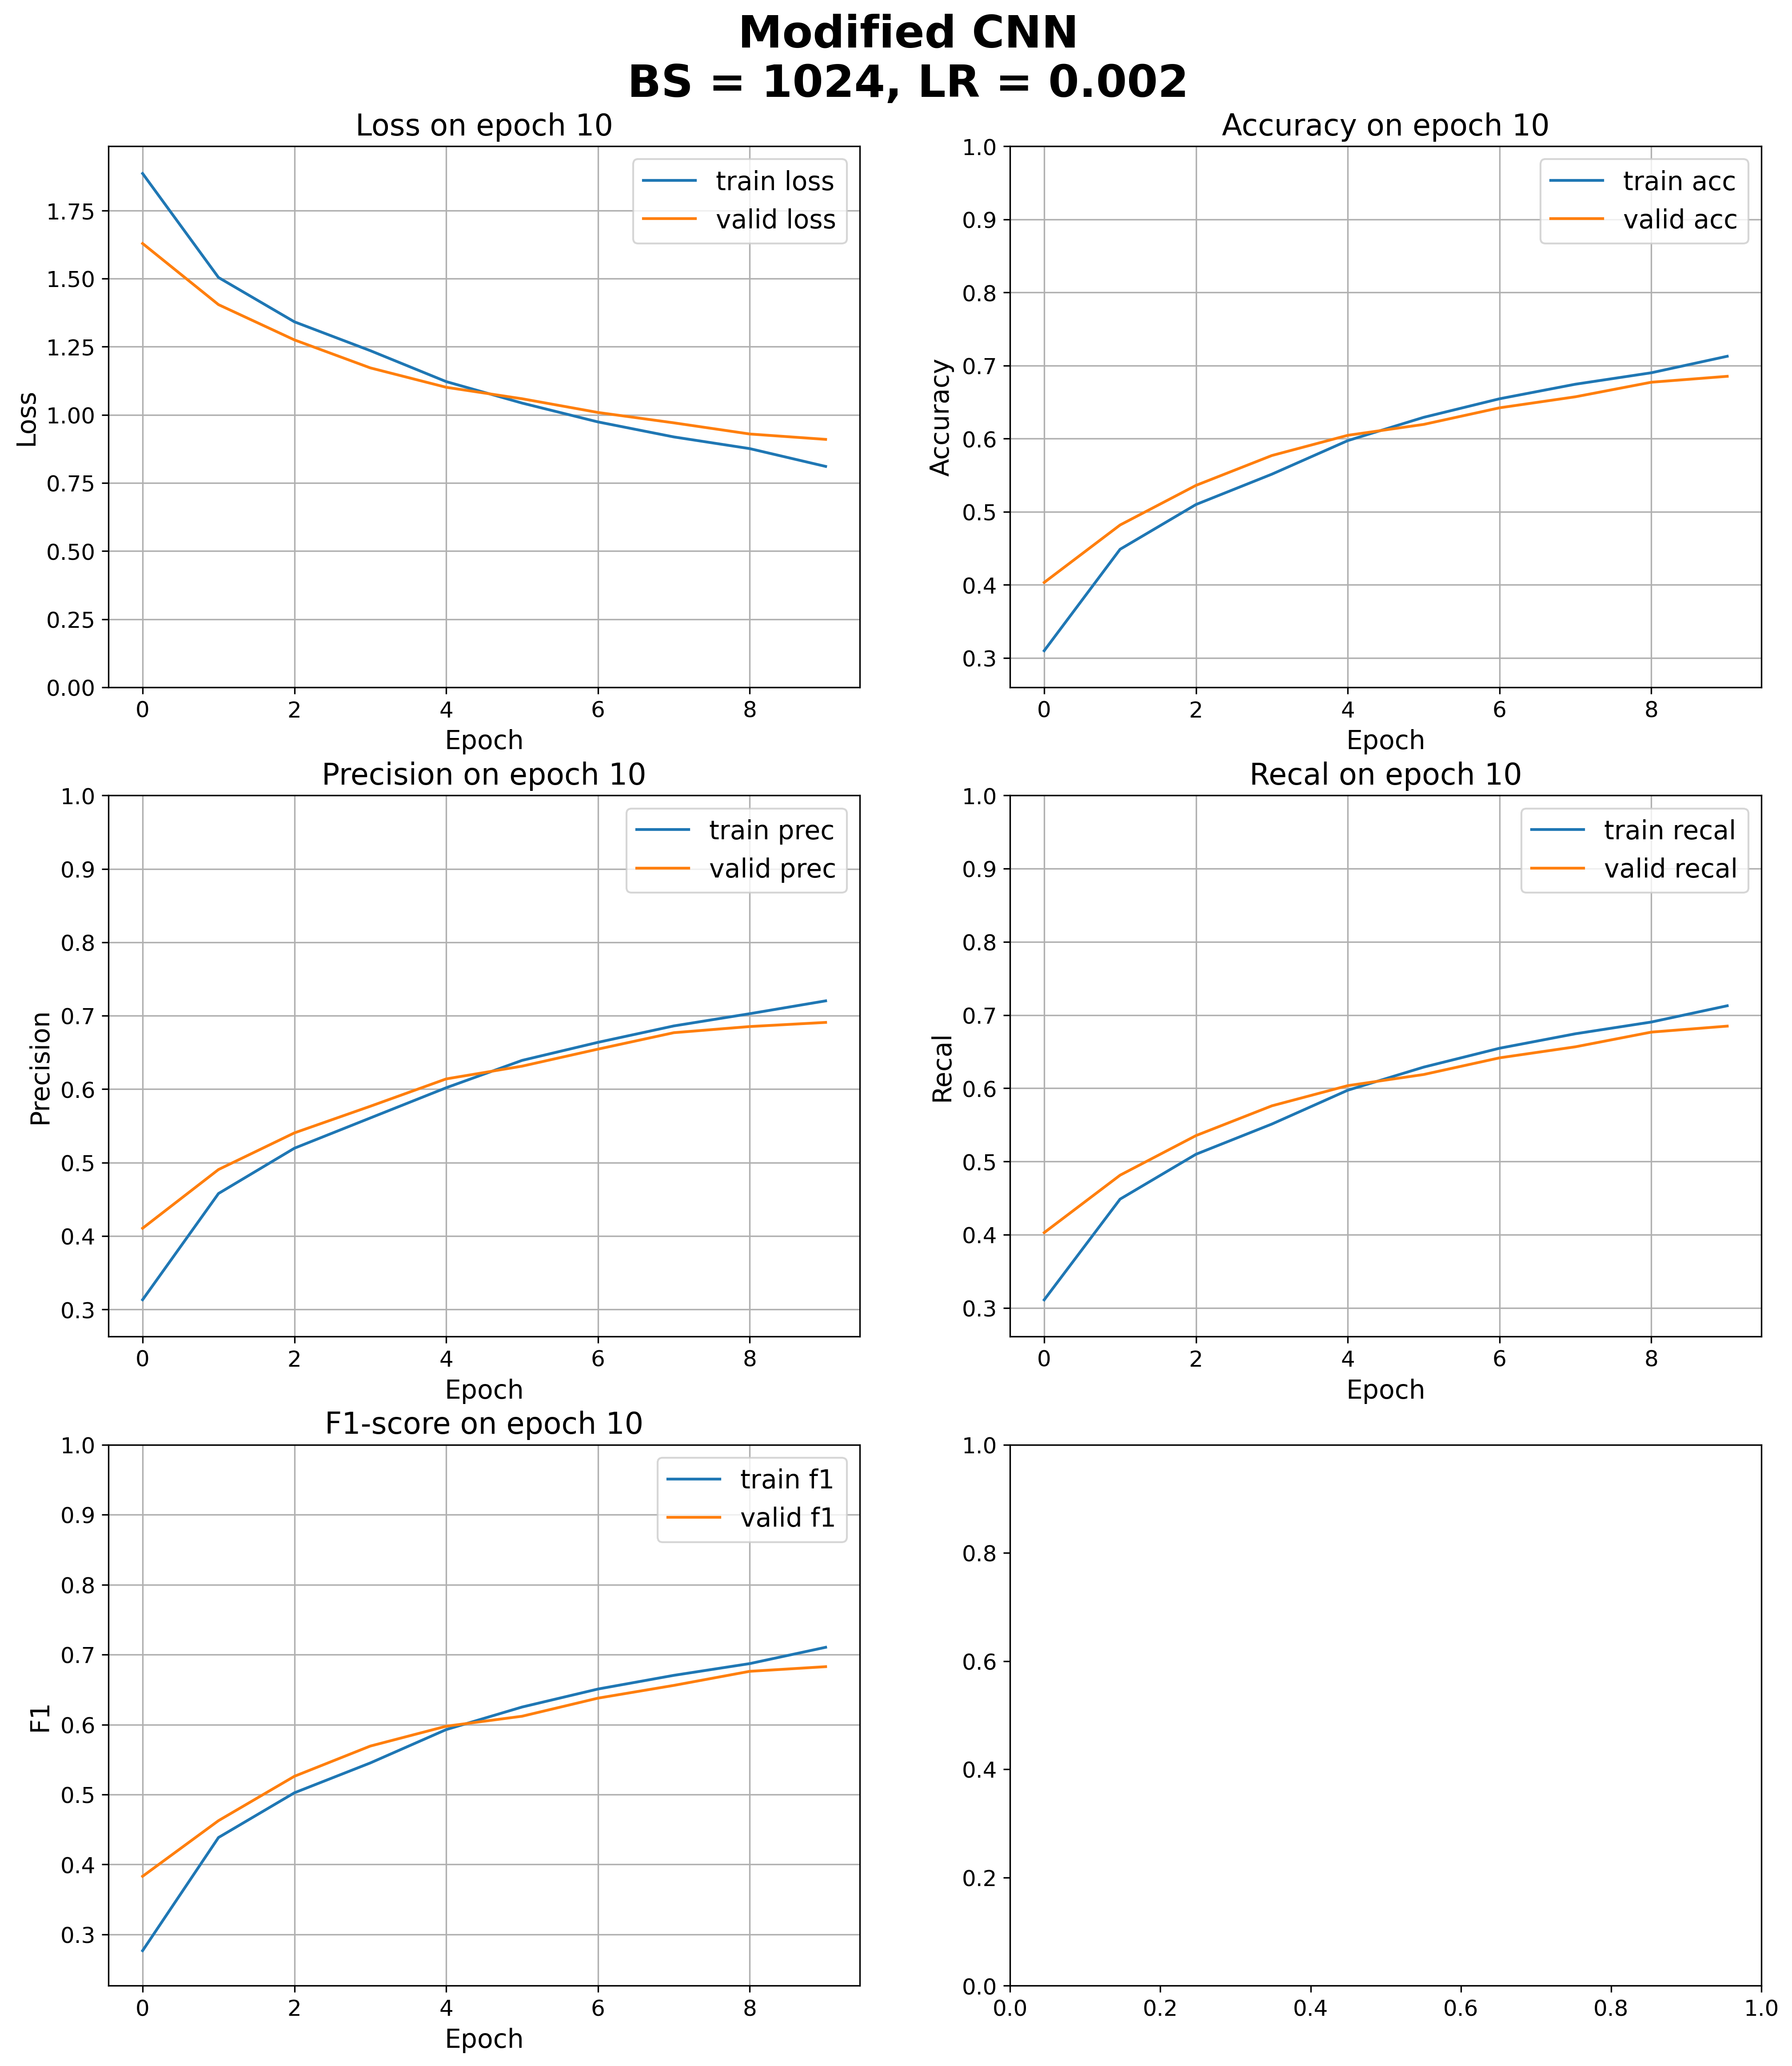

In [205]:
fig2 = plot_history(logs_2, suptitle=f"Modified CNN\nBS = {BATCH_SIZE}, LR = {lr2}")

In [206]:
fig2.savefig("results/imgs/Modified CNN.png", bbox_inches="tight", pad_inches=0.5)

10. Реализуй архитектуру, приведенную ниже на схеме. Повтори для нее шаги 6 и 7. 

![](img/big_cnn.png)

In [207]:
class BigCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flat = nn.Flatten()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,  # (w - k +2*p) / s + 1
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # на выходе 32х32
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,  # (w - k +2*p) / s + 1
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # на выходе 32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # на выходе 16x16
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,  # (w - k +2*p) / s + 1
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # на выходе 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,  # (w - k +2*p) / s + 1
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # на выходе 16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # на выходе 8x8
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,  # (w - k +2*p) / s + 1
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # на выходе 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,  # (w - k +2*p) / s + 1
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # на выходе 8x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # на выходе 4x4
        )
        self.fc1 = nn.Linear(4 * 4 * 256, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        x_1 = self.fc1(self.flat(out))
        x_2 = self.fc2(F.relu(x_1))
        x_3 = self.fc3(F.relu(x_2))
        x_final = x_3
        return x_final

In [208]:
big_cnn = BigCNN()
big_cnn.to(DEVICE)
;

''

In [209]:
tu.get_model_summary(big_cnn, torch.randn(32, 3, 32, 32, device=DEVICE))

Layer                          Kernel             Output          Params             FLOPs
0_layer1.Conv2d_0            [3, 32, 3, 3]    [32, 32, 32, 32]         896      29,360,128
1_layer1.ReLU_1                          -    [32, 32, 32, 32]           0               0
2_layer1.Conv2d_2           [32, 64, 3, 3]    [32, 64, 32, 32]      18,496     606,076,928
3_layer1.ReLU_3                          -    [32, 64, 32, 32]           0               0
4_layer1.MaxPool2d_4                     -    [32, 64, 16, 16]           0               0
5_layer2.Conv2d_0          [64, 128, 3, 3]   [32, 128, 16, 16]      73,856     605,028,352
6_layer2.BatchNorm2d_1               [128]   [32, 128, 16, 16]         256       4,194,304
7_layer2.ReLU_2                          -   [32, 128, 16, 16]           0               0
8_layer2.Conv2d_3         [128, 128, 3, 3]   [32, 128, 16, 16]     147,584   1,209,008,128
9_layer2.ReLU_4                          -   [32, 128, 16, 16]           0               0

In [210]:
lr3 = 1e-3
optimizer3 = torch.optim.Adam(
    big_cnn.parameters(), lr=lr3, weight_decay=0.01, amsgrad=True
)
criterion3 = torch.nn.CrossEntropyLoss()

In [211]:
# [MLflow] Запуск эксперимента через контекстный менеджер
if use_mlflow:
    mlflow.set_experiment(
        f"{mlflow_experiment_name} - Big CNN"
    )  # установить (или создать) эксперимент
    with mlflow.start_run(run_name=f"base_cnn_bs_{BATCH_SIZE}_lr_{lr3}"):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size", config["batch_size"])
        mlflow.log_param("learning_rate", lr3)
        mlflow.log_param("epochs", config["epochs"])
        mlflow.log_param("device", config["device"])
        mlflow.log_param("optimizer", optimizer3)
        mlflow.log_param("criterion", criterion3)

        # Запускаем обучение
        logs_3 = fit_model(
            model=big_cnn,
            epochs=config["epochs"],
            optimizer=optimizer3,
            criterion=criterion3,
            train_loader=train_loader,
            valid_loader=valid_loader,
        )

        # Сохраняем модель в MLflow (опционально)
        mlflow.pytorch.log_model(big_cnn, "model")

    # После выхода из `with` Run автоматически завершается
else:
    # Если не используем MLflow
    logs_3 = fit_model(
        model=big_cnn,
        epochs=config["epochs"],
        optimizer=optimizer3,
        criterion=criterion3,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

------------- Epoch 1 -------------
Train: loss 1.6873
accuracy 0.3679, F1-score 0.3380
precision 0.3642, recal 0.3682
Valid: loss 4.1251
accuracy 0.1250, F1-score 0.0492
precision 0.0423, recal 0.1254

-----------------------------------

------------- Epoch 2 -------------
Train: loss 1.2215
accuracy 0.5490, F1-score 0.5388
precision 0.5598, recal 0.5491
Valid: loss 1.2245
accuracy 0.5647, F1-score 0.5577
precision 0.6037, recal 0.5637

-----------------------------------

------------- Epoch 3 -------------
Train: loss 0.9573
accuracy 0.6555, F1-score 0.6509
precision 0.6662, recal 0.6557
Valid: loss 0.9586
accuracy 0.6629, F1-score 0.6590
precision 0.6835, recal 0.6622

-----------------------------------

------------- Epoch 4 -------------
Train: loss 0.7838
accuracy 0.7220, F1-score 0.7191
precision 0.7325, recal 0.7219
Valid: loss 0.8761
accuracy 0.6957, F1-score 0.6825
precision 0.7270, recal 0.6955

-----------------------------------

------------- Epoch 5 -------------
Trai

2025/09/10 13:24:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/10 13:24:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train: loss 0.4609
accuracy 0.8388, F1-score 0.8382
precision 0.8445, recal 0.8394
Valid: loss 0.7156
accuracy 0.7525, F1-score 0.7538
precision 0.7846, recal 0.7522

-----------------------------------



2025/09/10 13:24:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/10 13:24:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


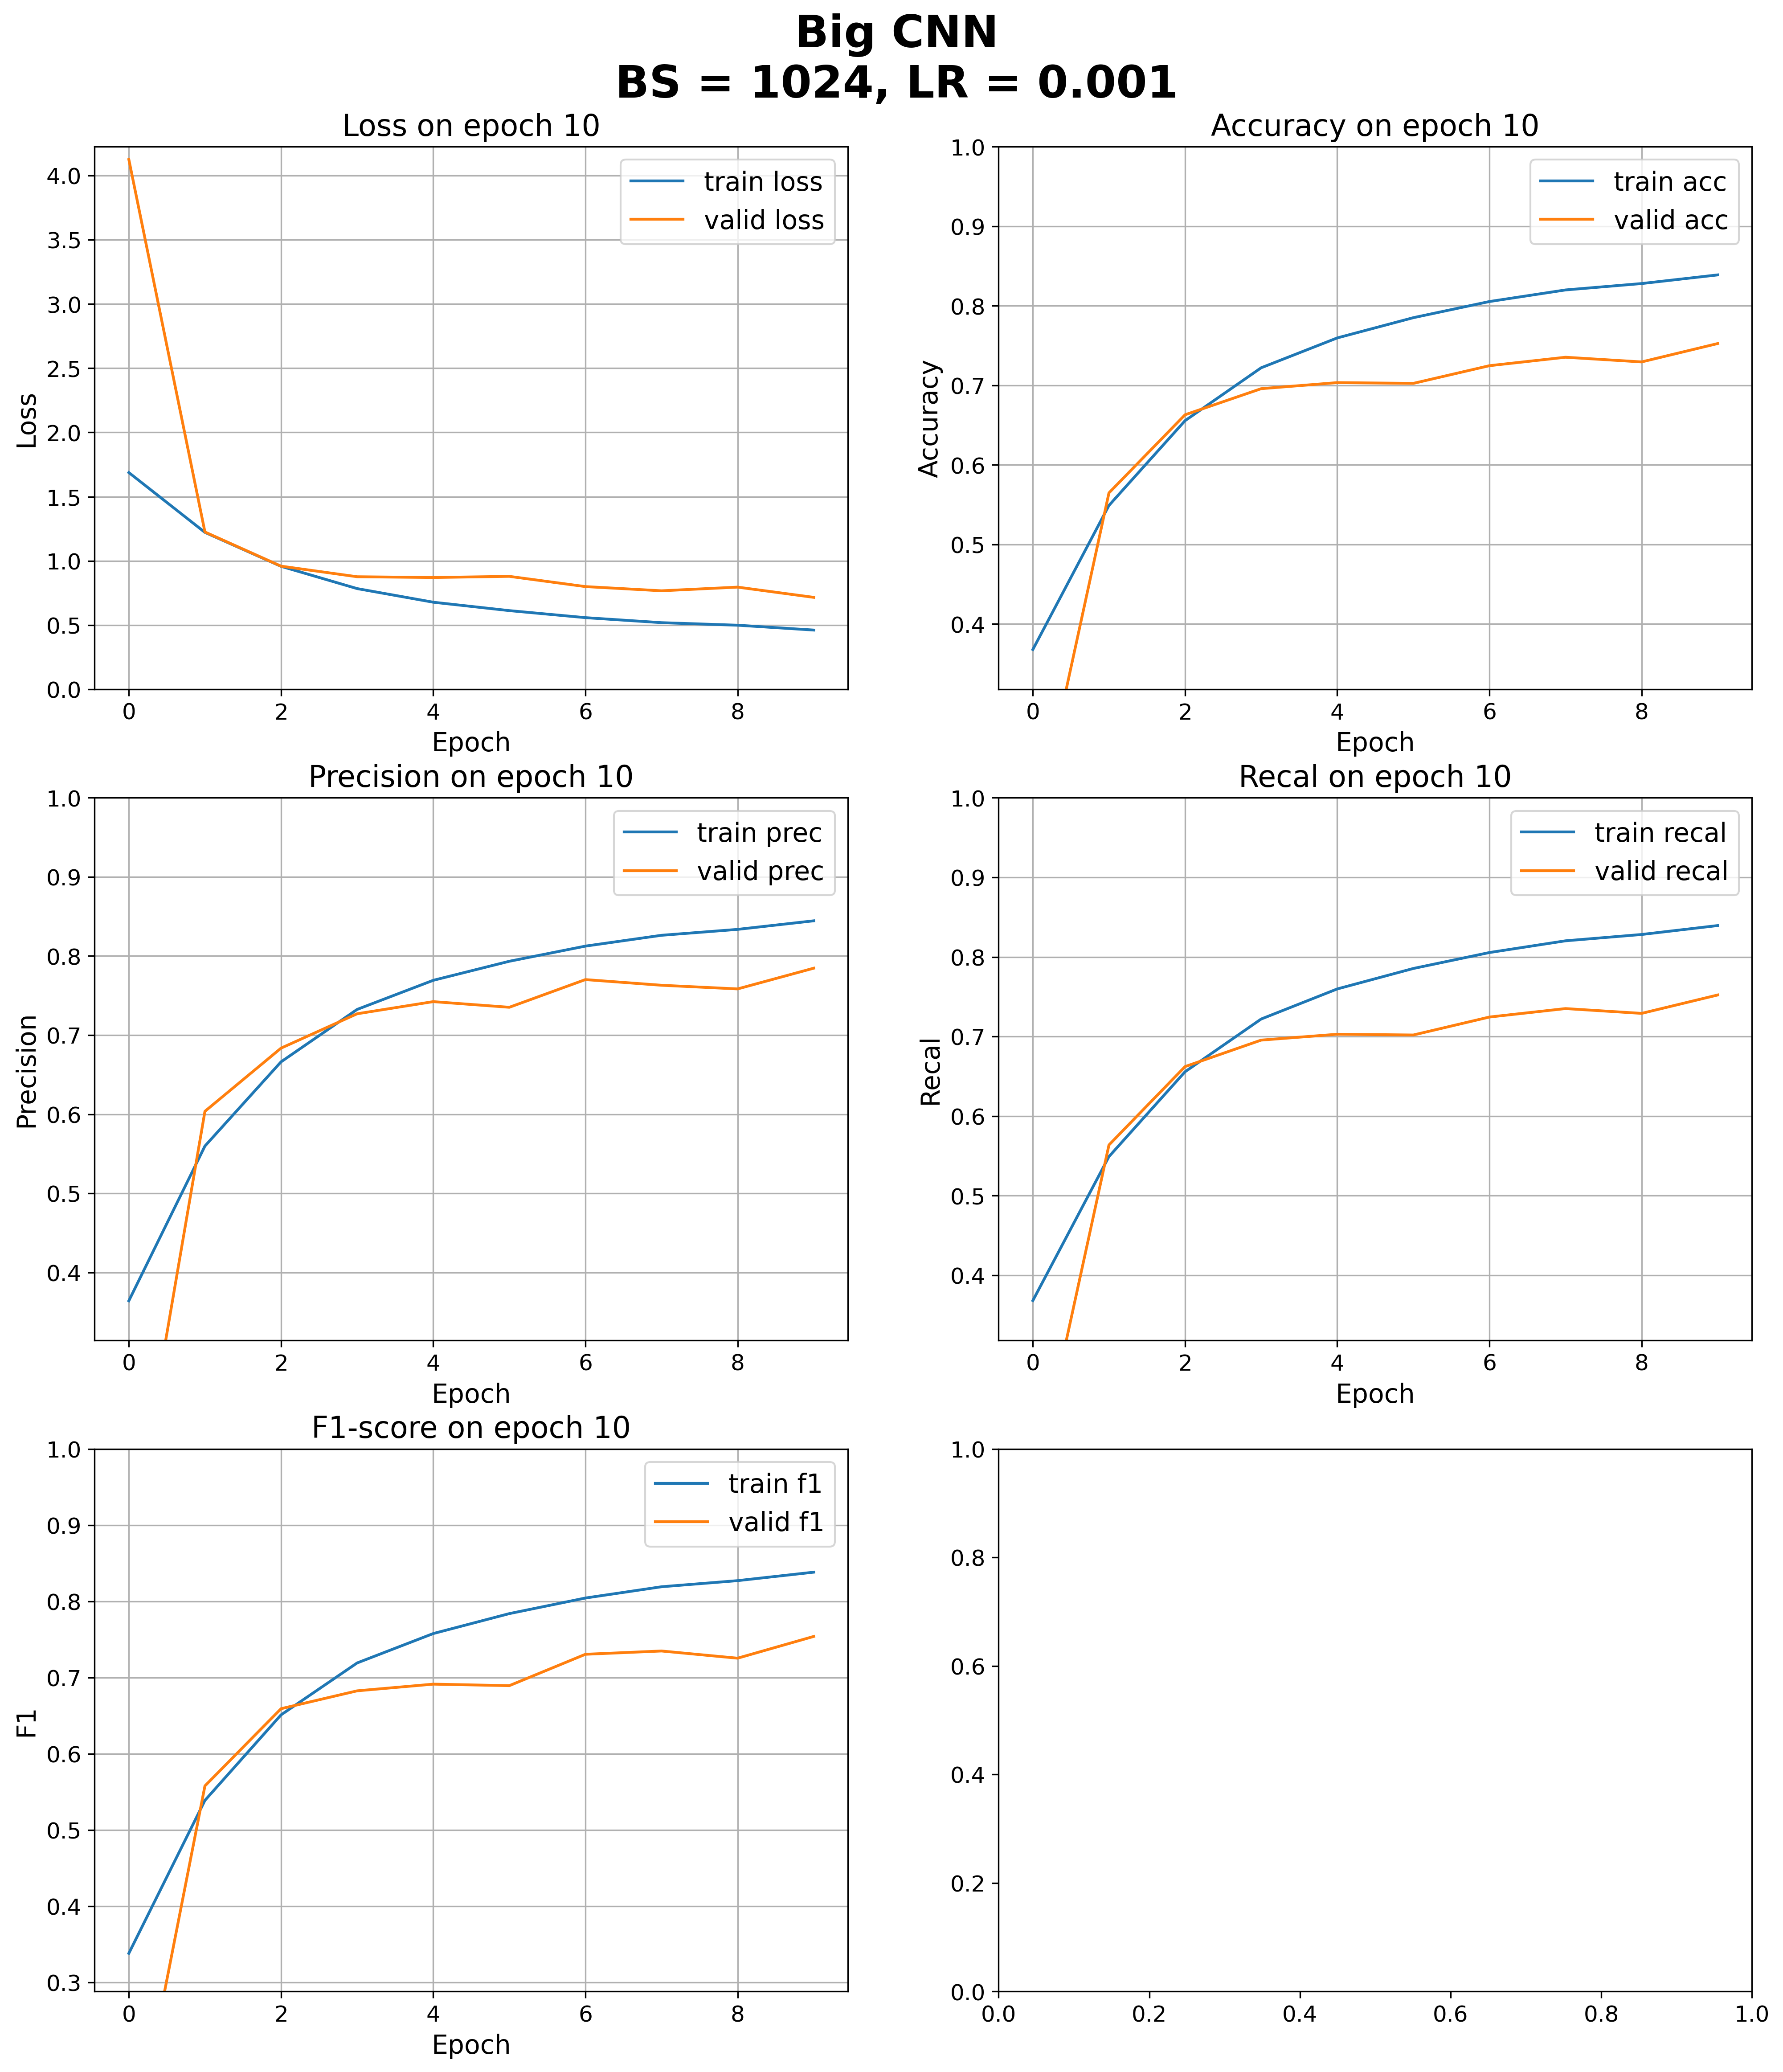

In [212]:
fig3 = plot_history(logs_3, suptitle=f"Big CNN\nBS = {BATCH_SIZE}, LR = {lr3}")

In [213]:
fig3.savefig("results/imgs/Big CNN.png", bbox_inches="tight", pad_inches=0.5)

In [214]:
metrics = pd.DataFrame(
    data={
        "Base CNN": np.round([c[-1] for c in logs.values()], 3),
        "Mod CNN": np.round([c[-1] for c in logs_2.values()], 3),
        "Big CNN": np.round([c[-1] for c in logs_3.values()], 3),
    },
    index=logs.keys(),
)
metrics

Base CNN  Mod CNN  Big CNN
train_losses     0.997    0.811    0.461
train_accs       0.649    0.713    0.839
train_precs      0.653    0.720    0.844
train_recals     0.649    0.713    0.839
train_f1s        0.645    0.710    0.838
valid_losses     1.062    0.910    0.716
valid_accs       0.622    0.685    0.752
valid_precs      0.618    0.691    0.785
valid_recals     0.621    0.685    0.752
valid_f1s        0.615    0.683    0.754

In [220]:
img, true_label = next(iter(valid_loader))
print(img.shape)
print(true_label[0])

torch.Size([1024, 3, 32, 32])
tensor(3, device='cuda:0')


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

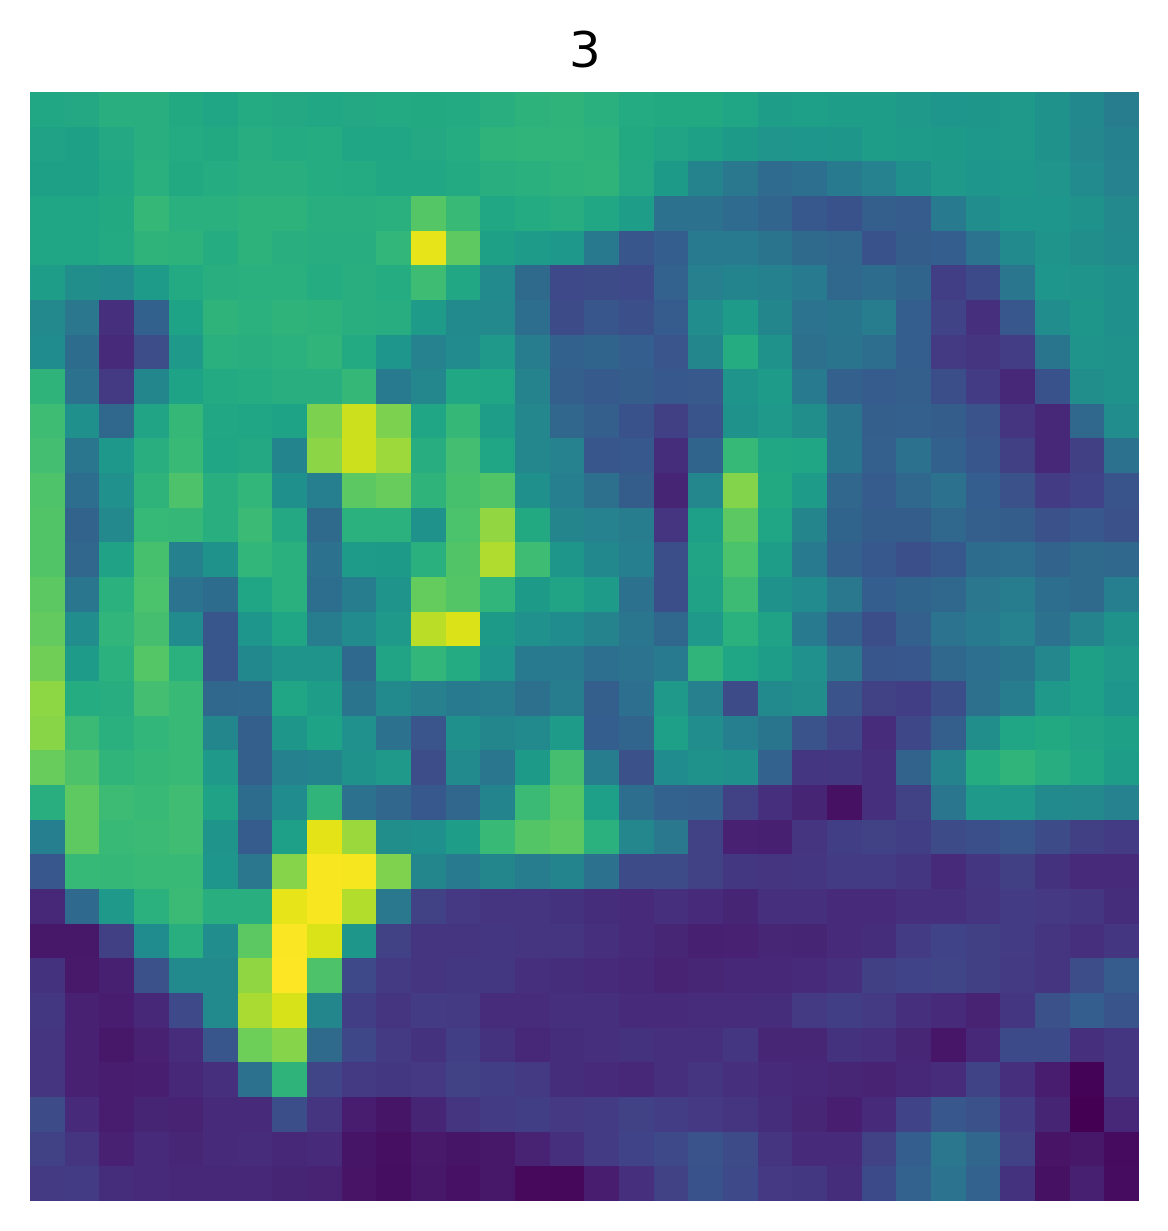

In [ ]:
plt.imshow(img[0][0])
plt.title(f"{true_label[0]}")
plt.axis("off")

In [ ]:
img[0].unsqueeze(0).shape
# img[0].unsqueeze(0) делает тензор с 1 в первой позиции для подачи на вход модели

torch.Size([1, 3, 32, 32])

In [225]:
with torch.inference_mode():
    pred_class = big_cnn(img[0].unsqueeze(0).to(DEVICE)).softmax(dim=1).argmax().item()
print(f"Pred class: {pred_class}")

Pred class: 3


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

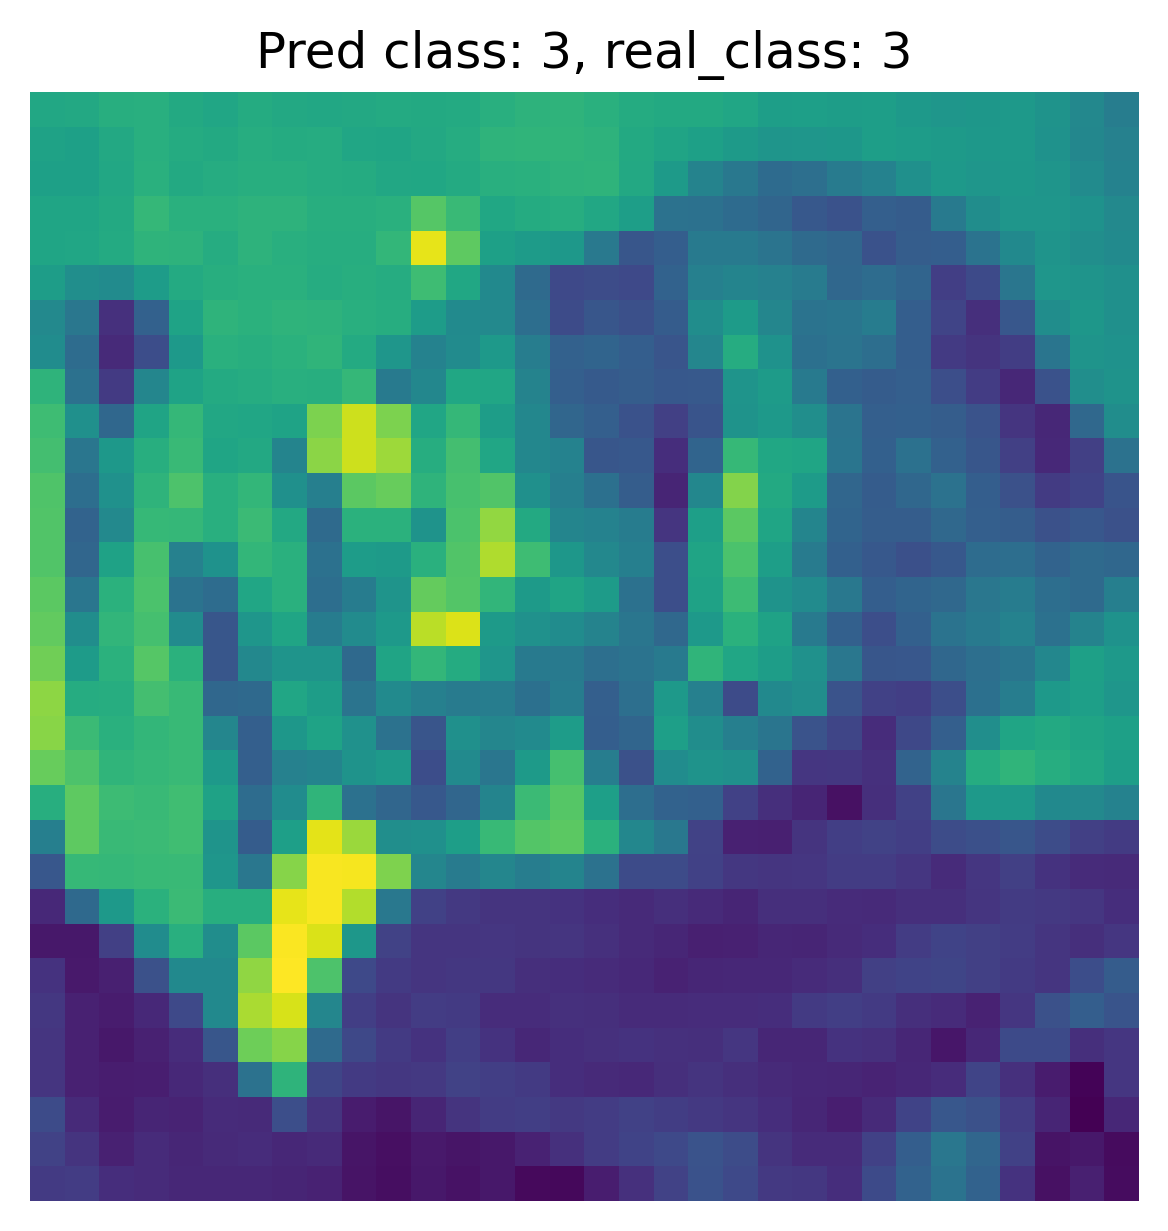

In [226]:
plt.imshow(img[0][0])
plt.title(f"Pred class: {pred_class}, real_class: {true_label[0]}")
plt.axis("off")

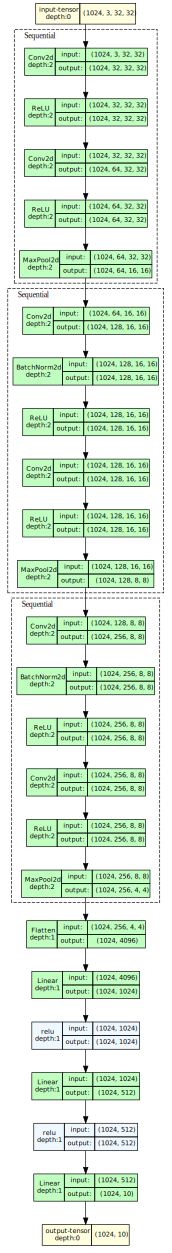

In [229]:
from torchview import draw_graph

model_graph = draw_graph(
    big_cnn, input_size=(config["batch_size"], 3, 32, 32), expand_nested=True
)
model_graph.visual_graph

11. Выясни по метриками, какая модель оказалась самой эффективной и сохрани в отдельный файл `best_model.py` ее класс, а в файл `best_model.pt` ее [веса](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference). 

In [ ]:
# torch.save(big_cnn.state_dict(), "results/models/big_cnn_weights.pt")

12. Используй модель, показавшую наибольшее качество. Обучи ее дважды на двух наборах данных: 
* Датасет без аугментаций (тот, который был создан выше)
* Датасет с аугментациями (их надо добавить в Compose в аргумент датасета transform): 
  * [ColorJitter](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter)
  * [RandomRotation](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html#torchvision.transforms.RandomRotation)
  * [RandomHorizontalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip)  
  
Для этого создай два новых датасета (обучение/валидация) с названиями `trani_aug_dataset` и `valid_aug_dataset` и два загрузчика `train_aug_loader` и `valid_aug_loader`. 


Обучение должно происходить в течение 30 эпох (модель, котоая будет учиться на аугментированных данных возможно придется обучать и дольше – надо следить за значениями функции потерь). 

❓ Какой из двух вариантов показывает лучшее качество на валидационной части данных: где данными выступали обычные изображения без аугментаций или аугментированные данные? 

In [250]:
augmentation = (
    T.ColorJitter(),  # Случайно меняет яркость, контраст, насыщенность и оттенок
    T.RandomRotation((0, 180)),  # Случайно поворачивает изображение
    T.RandomHorizontalFlip(
        p=0.5
    ),  # С вероятностью p отажает изображение по горизонтальной оси
)

train_aug_ds = CIFAR10(
    root="data/",
    download=True,
    train=True,
    transform=T.Compose(
        [
            T.Resize(
                (32, 32)
            ),  # на всякий случай применяем приведение к нужному размеру (тут он по умолчанию 32)
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # нормализация
            *augmentation,
        ]
    ),
)

valid_aug_ds = CIFAR10(
    root="data/",
    download=True,
    train=False,
    transform=T.Compose(
        [
            T.Resize((32, 32)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

In [303]:
lr4 = 1e-3
train_aug_loader = DataLoader(
    train_aug_ds,
    batch_size=BATCH_SIZE,
    generator=GENERATOR,
)
valid_aug_loader = DataLoader(
    valid_aug_ds,
    batch_size=BATCH_SIZE,
    generator=GENERATOR,
)
optimizer3_aug = torch.optim.Adamax(
    big_cnn.parameters(),
    lr=lr4,
    # weight_decay=0.01, amsgrad=True
)

In [304]:
# [MLflow] Запуск эксперимента через контекстный менеджер
if use_mlflow:
    mlflow.set_experiment(
        f"{mlflow_experiment_name} - Big CNN"
    )  # установить (или создать) эксперимент
    with mlflow.start_run(run_name=f"base_cnn_bs_{BATCH_SIZE}_lr_{lr4}"):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size", config["batch_size"])
        mlflow.log_param("learning_rate", lr4)
        mlflow.log_param("epochs", 30)
        mlflow.log_param("device", config["device"])
        mlflow.log_param("optimizer", optimizer3_aug)
        mlflow.log_param("criterion", criterion3)
        mlflow.log_param("Augmentation", augmentation)

        # Запускаем обучение
        logs_3_aug = fit_model(
            model=big_cnn,
            epochs=30,
            optimizer=optimizer3_aug,
            criterion=criterion3,
            train_loader=train_aug_loader,
            valid_loader=valid_aug_loader,
        )

        # Сохраняем модель в MLflow (опционально)
        mlflow.pytorch.log_model(big_cnn, "model")

    # После выхода из `with` Run автоматически завершается
else:
    # Если не используем MLflow
    logs_3_aug = fit_model(
        model=big_cnn,
        epochs=config["epochs"],
        optimizer=optimizer3_aug,
        criterion=criterion3,
        train_loader=train_aug_loader,
        valid_loader=valid_aug_loader,
    )

------------- Epoch 1 -------------
Train: loss 1.2308
accuracy 0.5505, F1-score 0.5430
precision 0.5431, recal 0.5509
Valid: loss 1.2674
accuracy 0.5350, F1-score 0.5253
precision 0.5519, recal 0.5345

-----------------------------------

------------- Epoch 2 -------------
Train: loss 1.1966
accuracy 0.5656, F1-score 0.5588
precision 0.5585, recal 0.5662
Valid: loss 1.2529
accuracy 0.5429, F1-score 0.5373
precision 0.5560, recal 0.5426

-----------------------------------

------------- Epoch 3 -------------
Train: loss 1.1823
accuracy 0.5709, F1-score 0.5644
precision 0.5640, recal 0.5716
Valid: loss 1.2054
accuracy 0.5579, F1-score 0.5514
precision 0.5687, recal 0.5576

-----------------------------------

------------- Epoch 4 -------------
Train: loss 1.1746
accuracy 0.5729, F1-score 0.5665
precision 0.5659, recal 0.5736
Valid: loss 1.2059
accuracy 0.5599, F1-score 0.5509
precision 0.5649, recal 0.5594

-----------------------------------

------------- Epoch 5 -------------
Trai

2025/09/10 17:44:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train: loss 1.0421
accuracy 0.6265, F1-score 0.6224
precision 0.6232, recal 0.6272
Valid: loss 1.0882
accuracy 0.6137, F1-score 0.6060
precision 0.6149, recal 0.6130

-----------------------------------



2025/09/10 17:44:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/10 17:44:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/10 17:44:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run base_cnn_bs_1024_lr_0.001 at: http://localhost:5000/#/experiments/889717902095099087/runs/96da8db84efd4370aa102902b49ad099
🧪 View experiment at: http://localhost:5000/#/experiments/889717902095099087


$\eta_t = \eta_{\min} + \frac{1}{2}(\eta_{\max} - \eta_{\min}) \left(
1 + \cos\left(\frac{T_{cur} \pi}{T_{max}}\right) \right)$

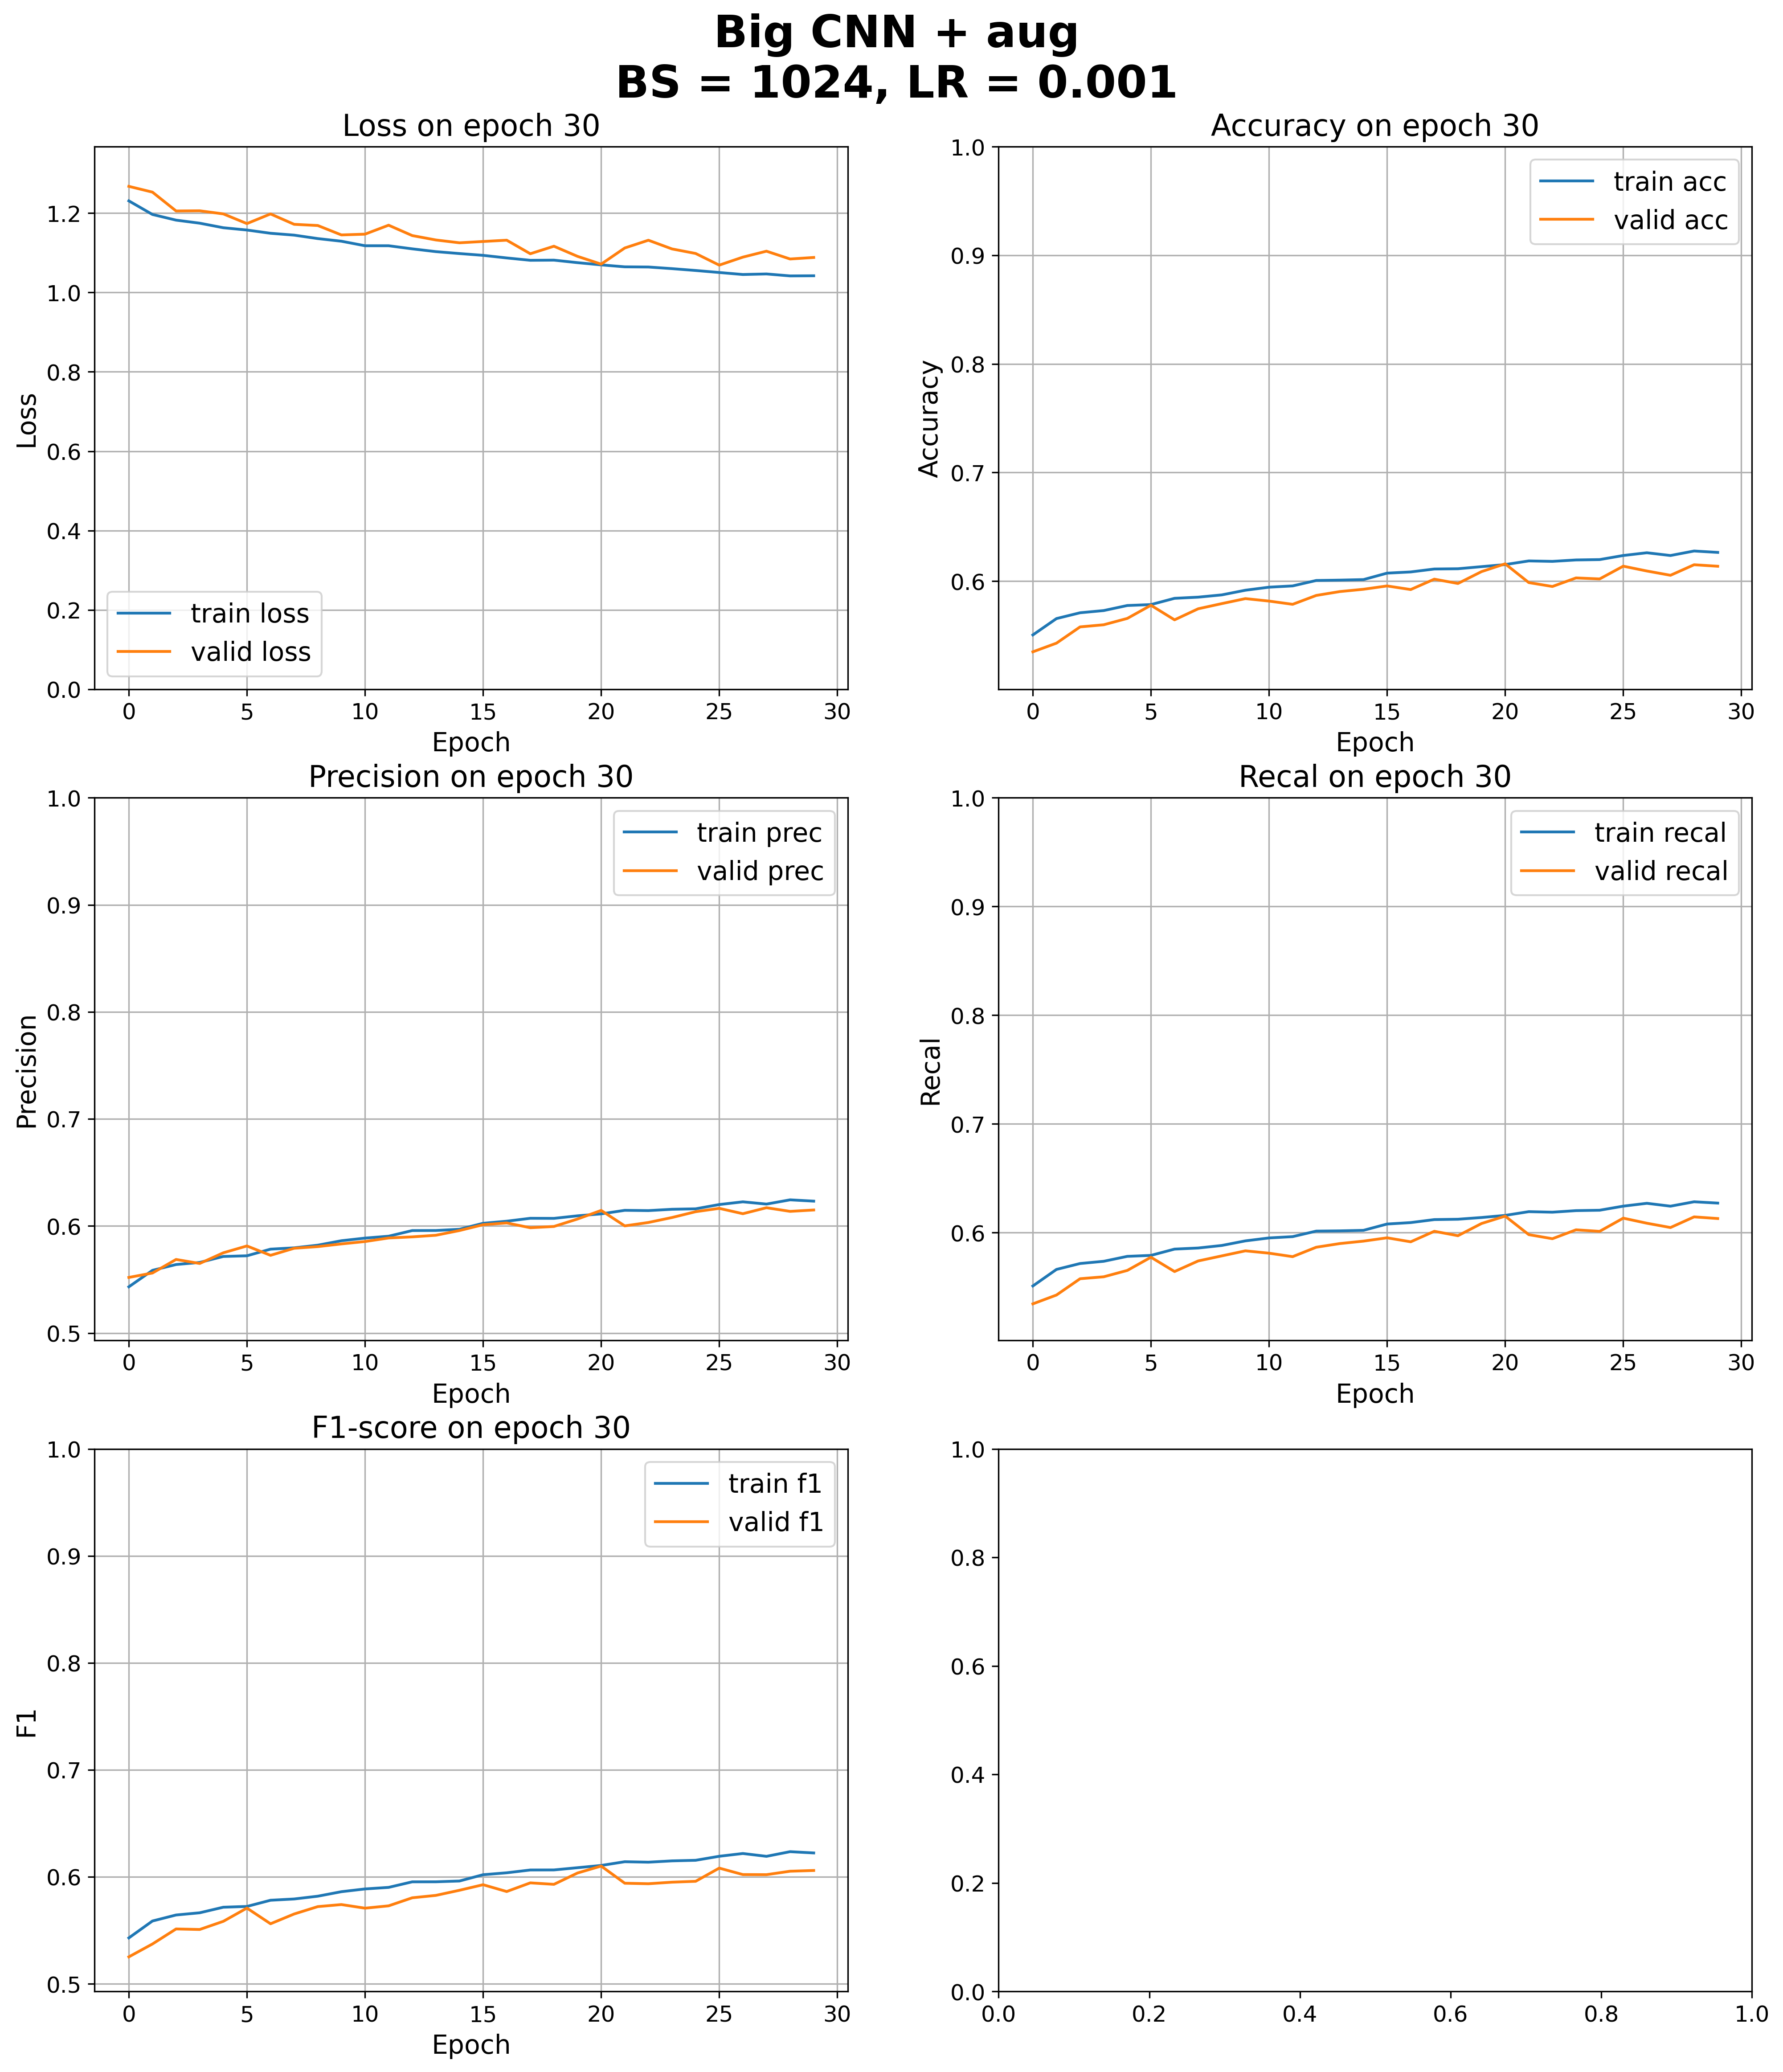

In [305]:
fig4 = plot_history(
    logs_3_aug, suptitle=f"Big CNN + aug\nBS = {BATCH_SIZE}, LR = {lr3}"
)

#### LeNet model

1. Реализуй модель LeNet в соответствии со схемой ниже, обучи её и сравни результаты с лучше собственной моделью (из реализованных выше). Число каналов во первом слое модели нужно изменить на 3, т.к. картинки цветные.  

<img src="https://www.philschmid.de/static/blog/getting-started-with-cnn-by-calculating-lenet-layer-manually/lenet-5.svg">

In [383]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=6,
                stride=1,
                kernel_size=5,
            ),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor):
        out = self.layer1(x)
        out = self.layer2(out)
        x_1 = self.fc1(self.flat(out))
        x_2 = self.fc2(F.relu(x_1))
        x_3 = self.fc3(F.relu(x_2))
        return x_3

In [384]:
lenet = LeNet()
lenet.to(DEVICE)
lr_lenet = 5e-2
optimizer_lenet = torch.optim.SGD(
    lenet.parameters(),
    # lr=lr_lenet,
    momentum=0.9,
    nesterov=True,
    # weight_decay=1e-4,
    # amsgrad=True
)

In [385]:
train_loader_lenet = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    generator=GENERATOR,
    shuffle=True,  # перемешиваем данные для обучения
    num_workers=4,  # подстрой под свои CPU-ядра
    pin_memory=True,  # ускоряет передачу CPU→GPU
    persistent_workers=True,  # не пересоздаёт воркеров на каждой эпохе
    prefetch_factor=2,  # (по умолчанию 2) батчей на воркер вперёд
    drop_last=True,  # убираем неполный батч (оптимальнее для тренировки)
)
valid_loader_lenet = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    generator=GENERATOR,
    shuffle=False,  # валидацию не перемешиваем
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

In [386]:
# [MLflow] Запуск эксперимента через контекстный менеджер
if use_mlflow:
    mlflow.set_experiment(
        f"{mlflow_experiment_name} - LeNet"
    )  # установить (или создать) эксперимент
    with mlflow.start_run(run_name=f"base_cnn_bs_{BATCH_SIZE}_lr_{lr_lenet}"):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size", config["batch_size"])
        mlflow.log_param("learning_rate", lr_lenet)
        mlflow.log_param("epochs", 50)
        mlflow.log_param("device", config["device"])
        mlflow.log_param("optimizer", optimizer_lenet)
        mlflow.log_param("criterion", criterion3)
        mlflow.log_param("Augmentation", "No")

        # Запускаем обучение
        logs_lenet = fit_model(
            model=lenet,
            epochs=50,
            optimizer=optimizer_lenet,
            criterion=criterion3,
            train_loader=train_loader_lenet,
            valid_loader=valid_loader_lenet,
        )

        # Сохраняем модель в MLflow (опционально)
        mlflow.pytorch.log_model(lenet, "model")

    # После выхода из `with` Run автоматически завершается
else:
    # Если не используем MLflow
    logs_lenet = fit_model(
        model=lenet,
        epochs=50,
        optimizer=optimizer_lenet,
        criterion=criterion3,
        train_loader=train_loader_lenet,
        valid_loader=valid_loader_lenet,
    )

------------- Epoch 1 -------------
Train: loss 2.3048
accuracy 0.1005, F1-score 0.0491
precision 0.0732, recal 0.1003
Valid: loss 2.3037
accuracy 0.1013, F1-score 0.0229
precision 0.0806, recal 0.1012

-----------------------------------

------------- Epoch 2 -------------
Train: loss 2.3004
accuracy 0.1054, F1-score 0.0544
precision 0.0809, recal 0.1055
Valid: loss 2.2981
accuracy 0.1057, F1-score 0.0516
precision 0.0843, recal 0.1056

-----------------------------------

------------- Epoch 3 -------------
🏃 View run base_cnn_bs_2048_lr_0.05 at: http://localhost:5000/#/experiments/774890097085623288/runs/14cb69b2cf5540a1a648113d734d0baf
🧪 View experiment at: http://localhost:5000/#/experiments/774890097085623288


KeyboardInterrupt: 

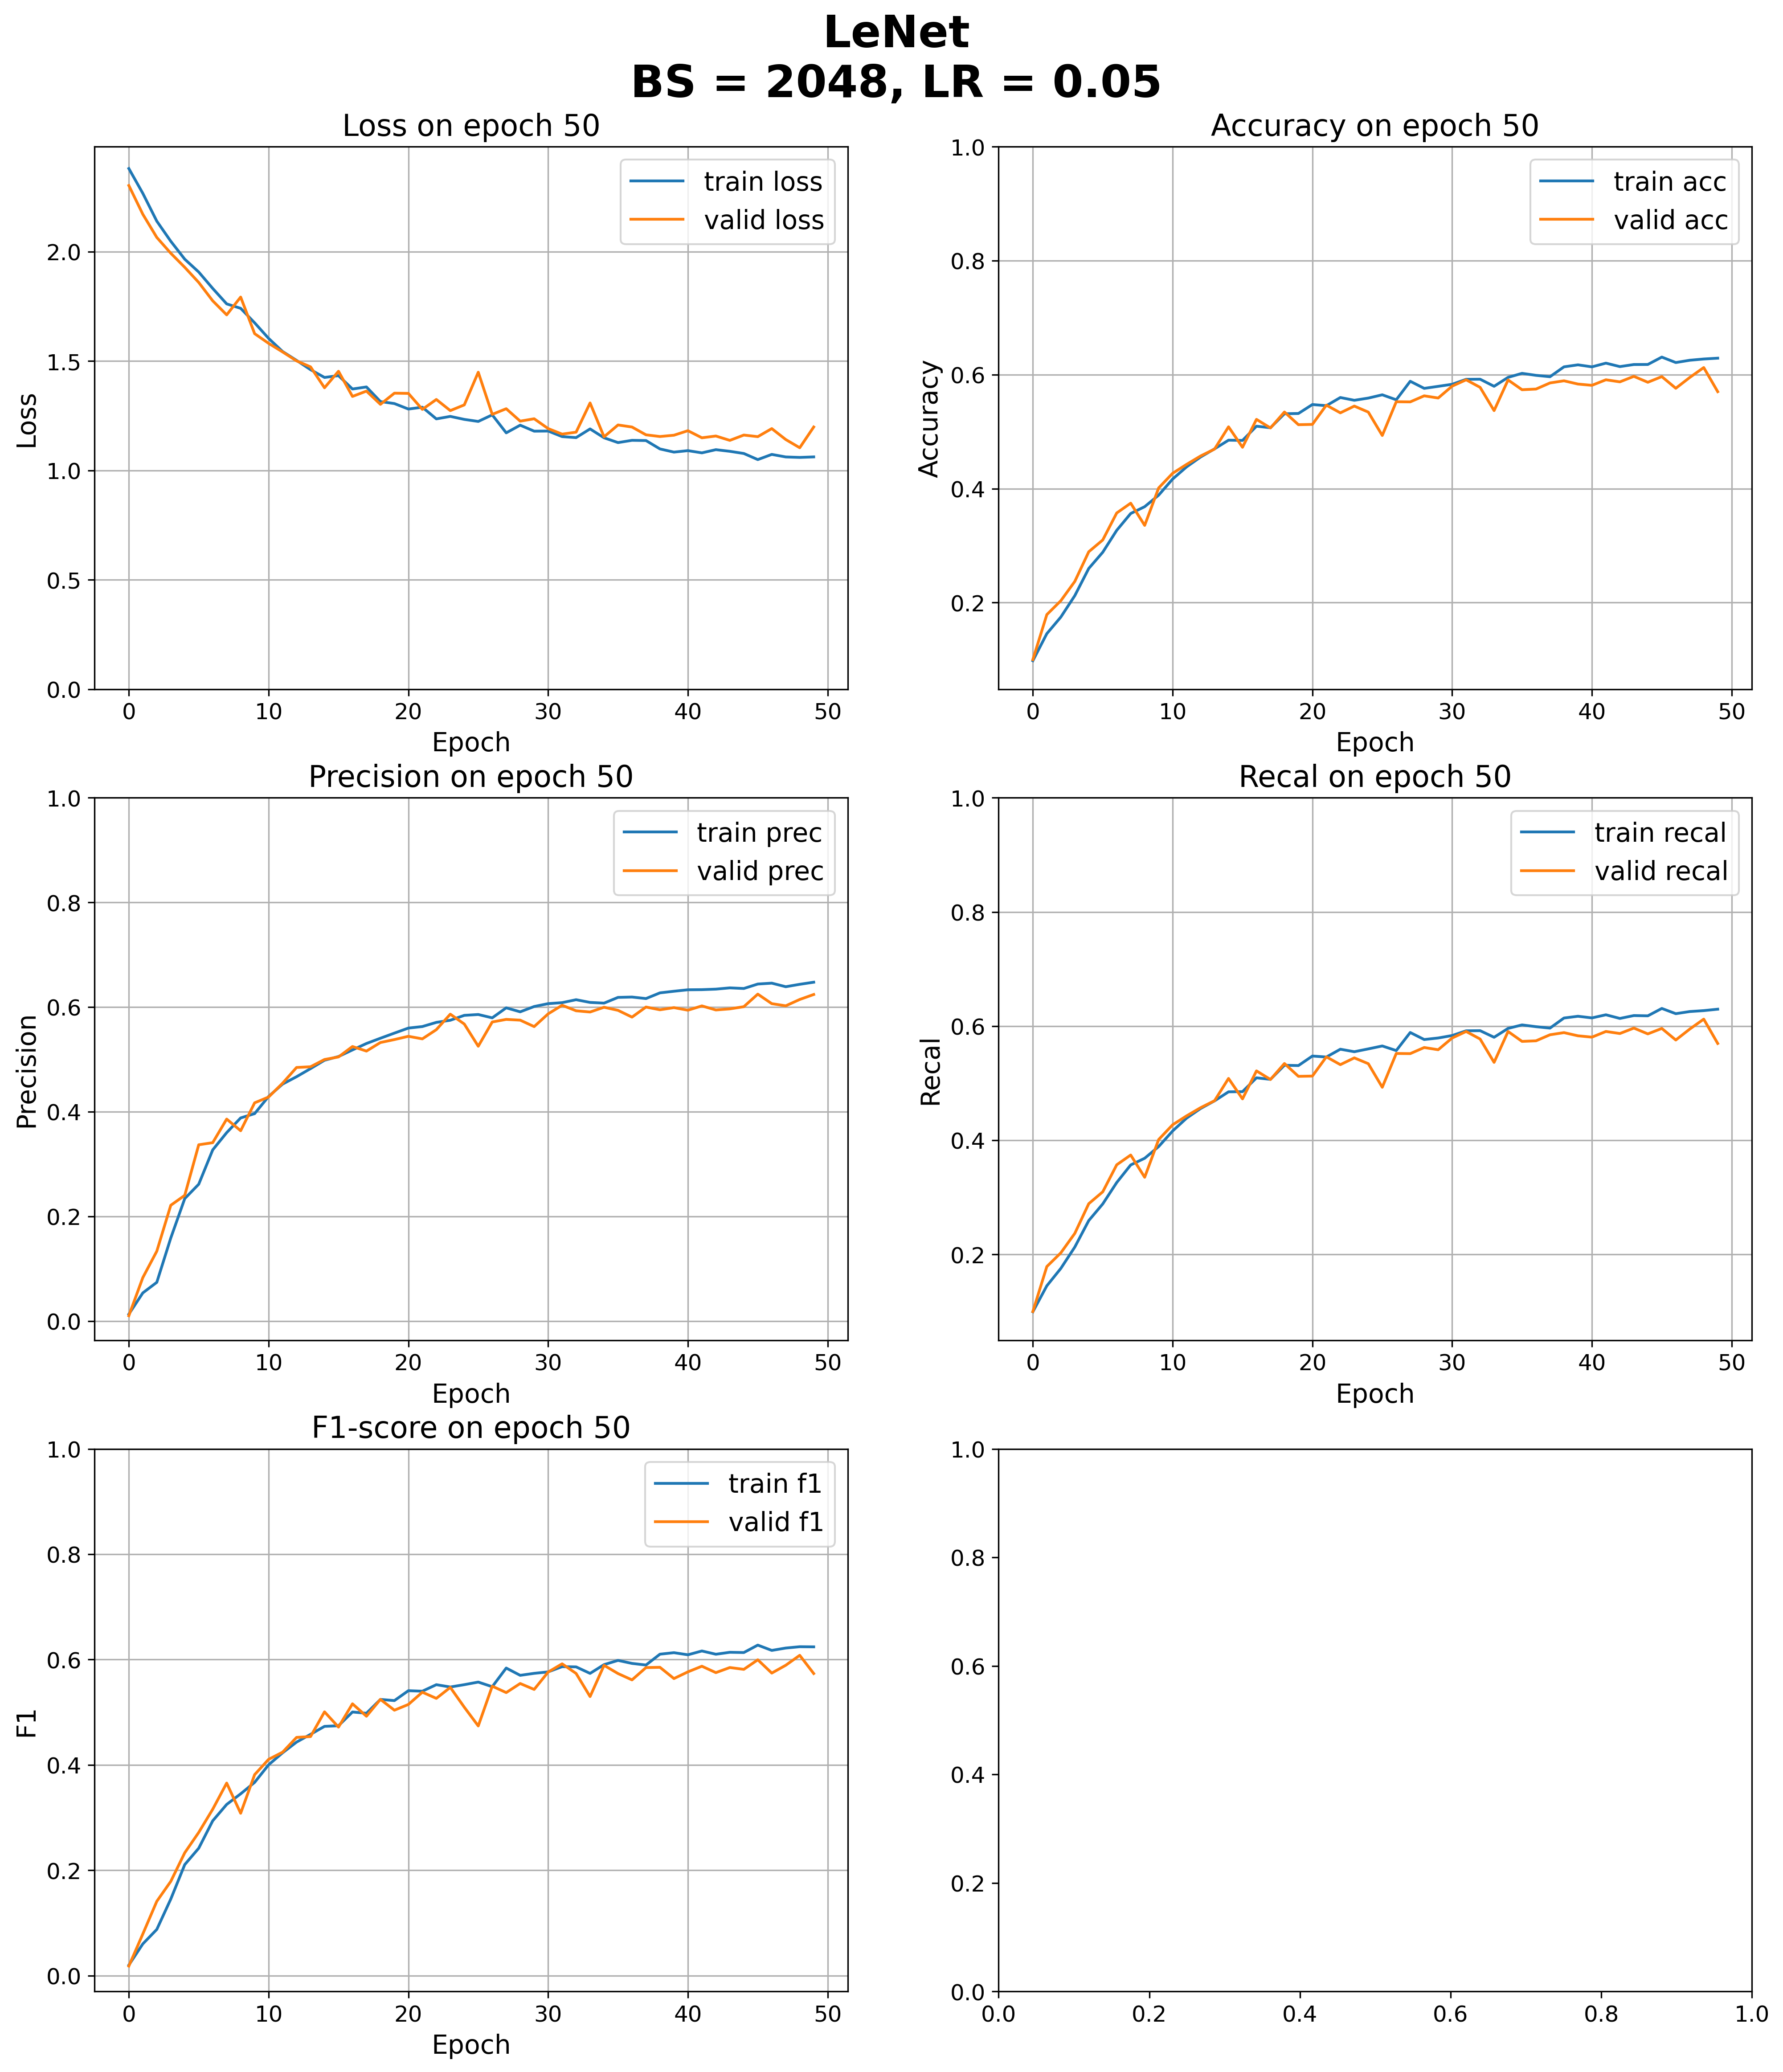

In [370]:
fig_5 = plot_history(logs_lenet, suptitle=f"LeNet\nBS = {BATCH_SIZE}, LR = {lr_lenet}")

2. Обучи новый экземпляр модели LeNet, но на этот раз добавь в функцию потерь аргумент `label_smoothing=.2`. Сравни результат с предыдущим этапом. 

In [371]:
criterion_lenet_2 = torch.nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer_lenet_2 = torch.optim.Adam(
    lenet.parameters(),
    lr=lr_lenet,
    weight_decay=1e-4,
)

In [372]:
# [MLflow] Запуск эксперимента через контекстный менеджер
if use_mlflow:
    mlflow.set_experiment(
        f"{mlflow_experiment_name} - LeNet"
    )  # установить (или создать) эксперимент
    with mlflow.start_run(run_name=f"base_cnn_bs_{BATCH_SIZE}_lr_{lr_lenet}"):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size", config["batch_size"])
        mlflow.log_param("learning_rate", lr_lenet)
        mlflow.log_param("epochs", config["epochs"])
        mlflow.log_param("device", config["device"])
        mlflow.log_param("optimizer", optimizer_lenet)
        mlflow.log_param("criterion", criterion3)
        mlflow.log_param("Augmentation", "No")
        mlflow.log_param("label_smoothing", 0.2)

        # Запускаем обучение
        logs_lenet_2 = fit_model(
            model=lenet,
            epochs=30,
            optimizer=optimizer_lenet_2,
            criterion=criterion_lenet_2,
            train_loader=train_loader,
            valid_loader=valid_loader,
        )

        # Сохраняем модель в MLflow (опционально)
        mlflow.pytorch.log_model(lenet, "model")

    # После выхода из `with` Run автоматически завершается
else:
    # Если не используем MLflow
    logs_lenet_2 = fit_model(
        model=lenet,
        epochs=30,
        optimizer=optimizer_lenet_2,
        criterion=criterion_lenet_2,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

------------- Epoch 1 -------------
Train: loss 2.1872
accuracy 0.3474, F1-score 0.3083
precision 0.3396, recal 0.3479
Valid: loss 1.8188
accuracy 0.4693, F1-score 0.4369
precision 0.4703, recal 0.4683

-----------------------------------

------------- Epoch 2 -------------
Train: loss 1.7121
accuracy 0.5271, F1-score 0.5152
precision 0.5407, recal 0.5271
Valid: loss 1.6884
accuracy 0.5385, F1-score 0.5190
precision 0.5496, recal 0.5380

-----------------------------------

------------- Epoch 3 -------------
Train: loss 1.6492
accuracy 0.5646, F1-score 0.5570
precision 0.5816, recal 0.5652
Valid: loss 1.6773
accuracy 0.5526, F1-score 0.5344
precision 0.5638, recal 0.5519

-----------------------------------

------------- Epoch 4 -------------
Train: loss 1.6201
accuracy 0.5807, F1-score 0.5737
precision 0.5982, recal 0.5810
Valid: loss 1.6248
accuracy 0.5741, F1-score 0.5699
precision 0.6046, recal 0.5739

-----------------------------------

------------- Epoch 5 -------------
Trai

2025/09/10 18:34:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train: loss 1.5154
accuracy 0.6422, F1-score 0.6386
precision 0.6599, recal 0.6424
Valid: loss 1.5292
accuracy 0.6291, F1-score 0.6242
precision 0.6391, recal 0.6288

-----------------------------------



2025/09/10 18:34:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/10 18:34:32 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/10 18:34:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run base_cnn_bs_2048_lr_0.05 at: http://localhost:5000/#/experiments/774890097085623288/runs/830747f78877482c9e9604a5ab285b75
🧪 View experiment at: http://localhost:5000/#/experiments/774890097085623288


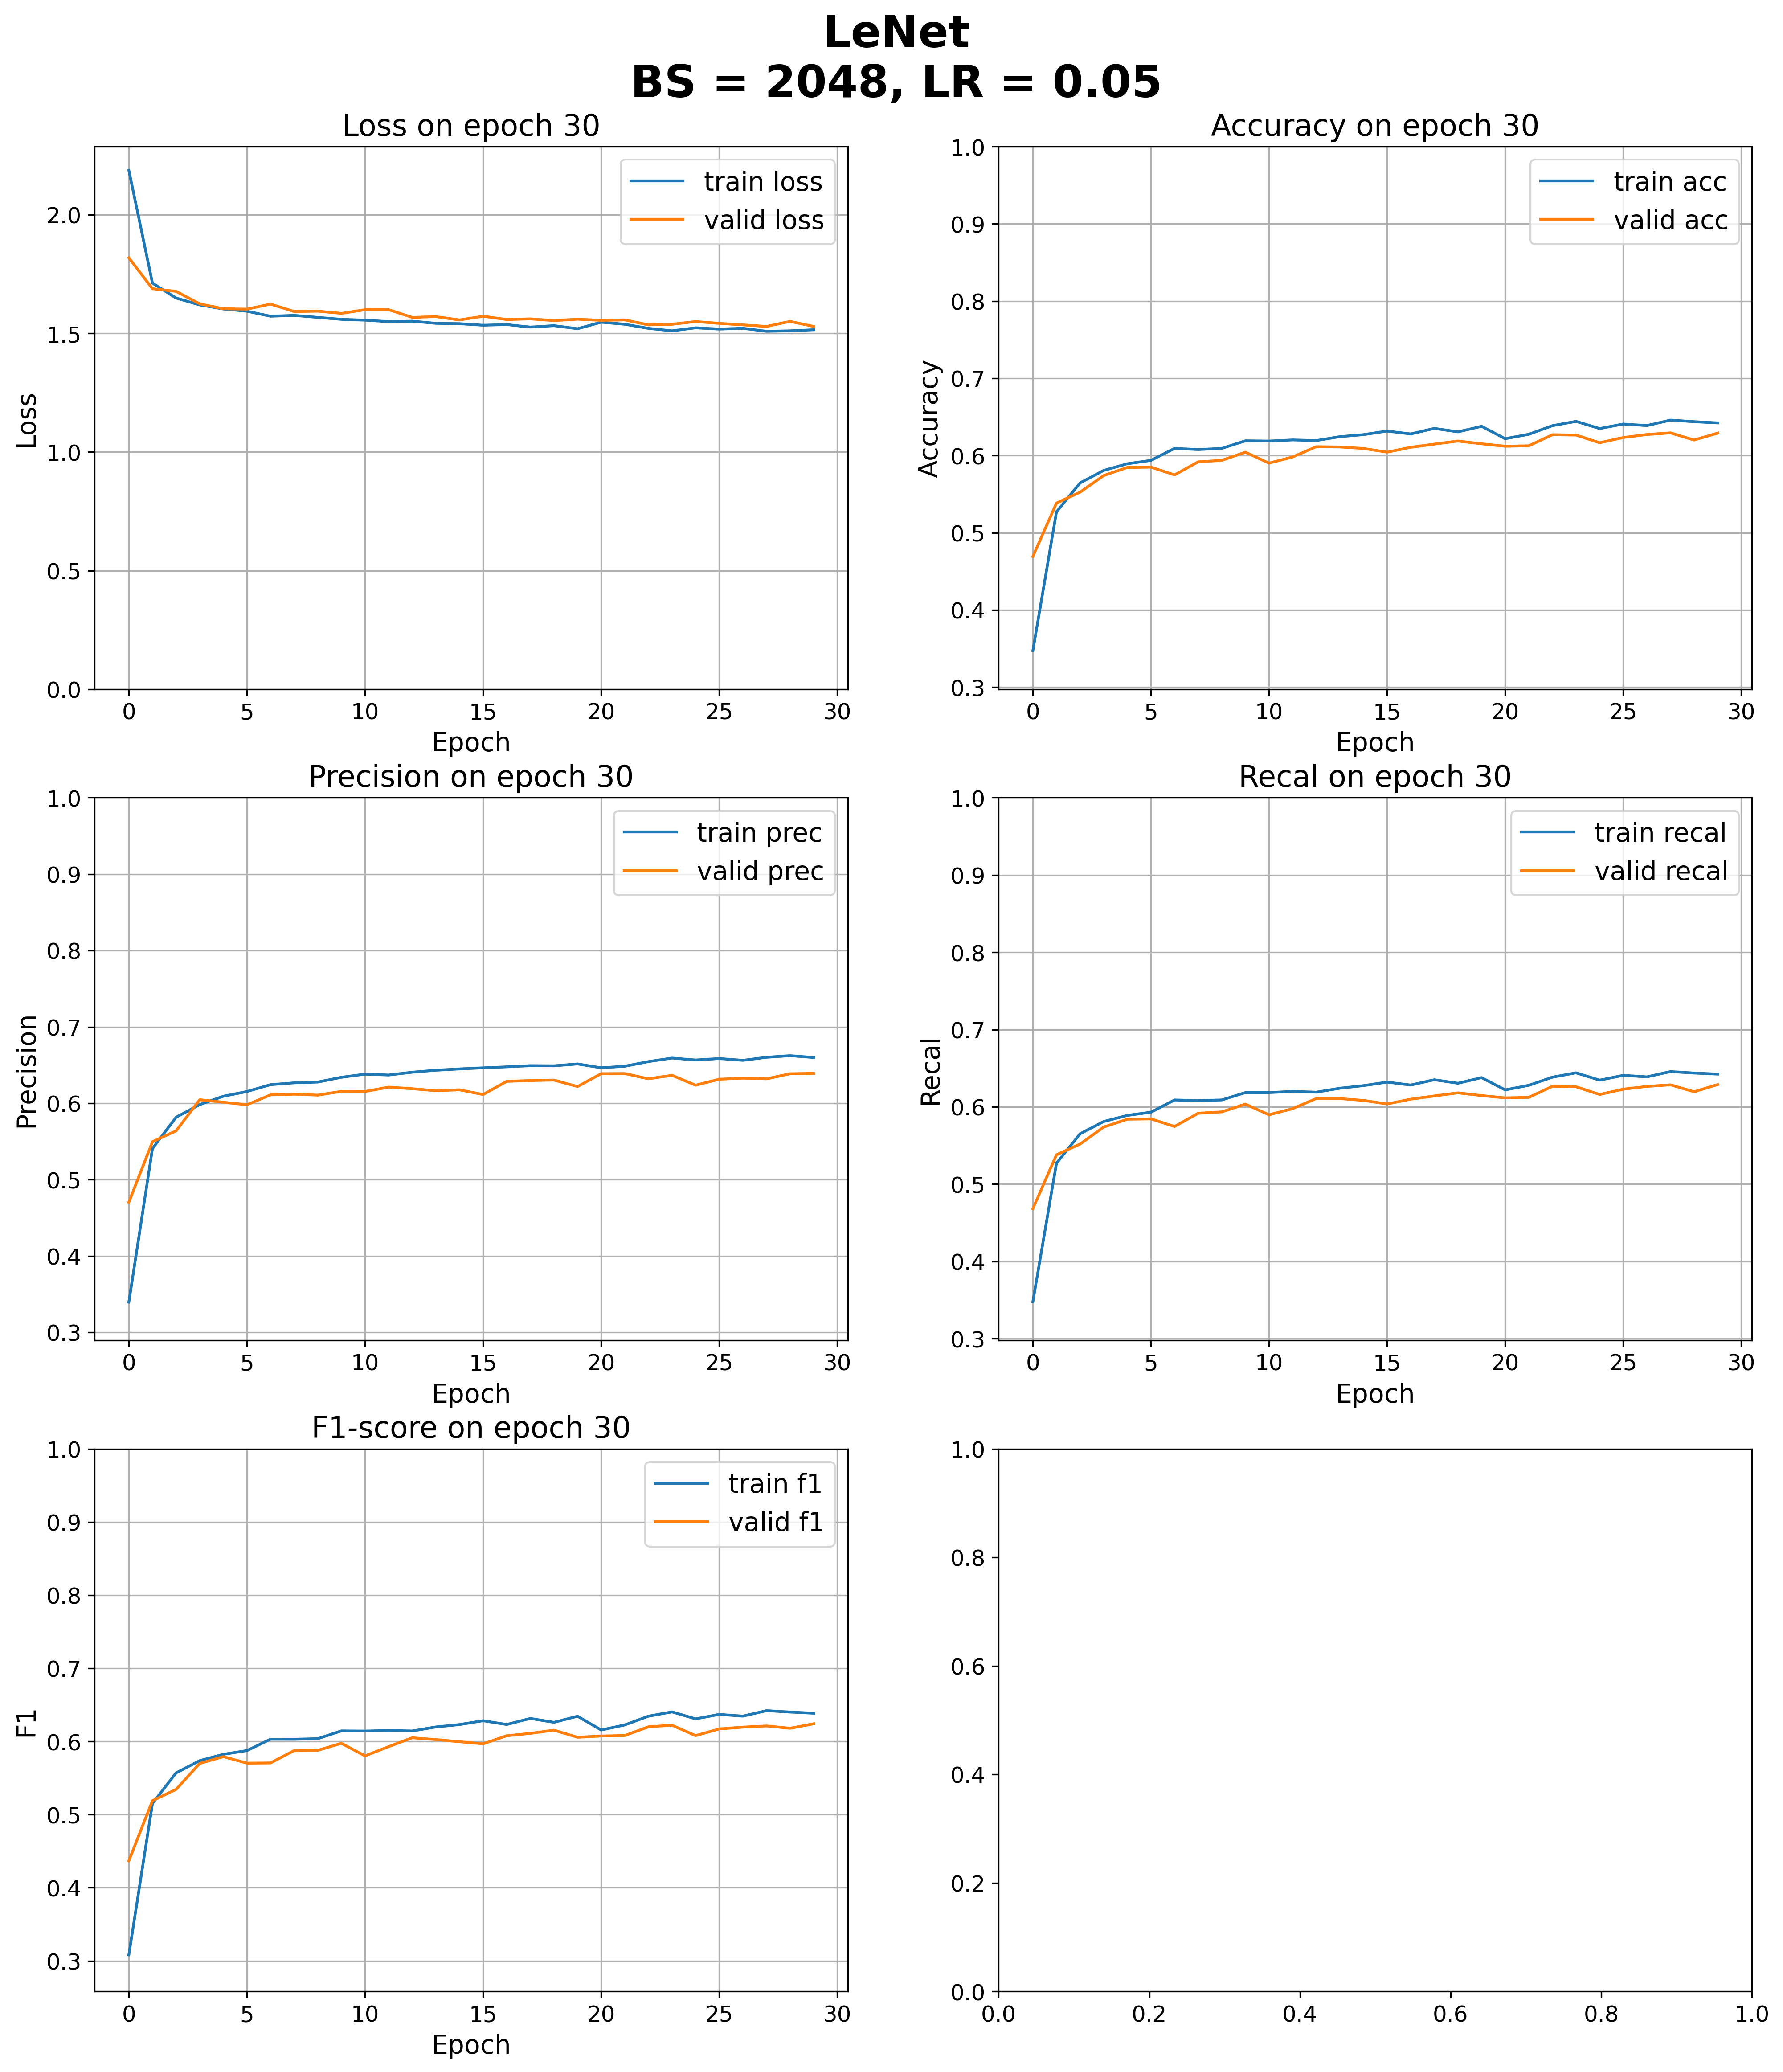

In [373]:
fig_6 = plot_history(
    logs_lenet_2, suptitle=f"LeNet\nBS = {BATCH_SIZE}, LR = {lr_lenet}"
)